<a href="https://colab.research.google.com/github/shikharkyadesultory/MB-Localization-TLFIM-/blob/main/my_module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Implementing a Matrix Product State**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pylab as pl

In [4]:


import numpy as np
from scipy.linalg import svd



class SimpleMPS:

    def __init__(self, Bs, Ss, bc='finite'):
        assert bc in ['finite', 'infinite']
        self.Bs = Bs
        self.Ss = Ss
        self.bc = bc
        self.L = len(Bs)
        self.nbonds = self.L - 1 if self.bc == 'finite' else self.L

    def copy(self):
        return SimpleMPS([B.copy() for B in self.Bs], [S.copy() for S in self.Ss], self.bc)

    def get_theta1(self, i):

        return np.tensordot(np.diag(self.Ss[i]), self.Bs[i], [1, 0])  # vL [vL'], [vL] i vR

    def get_theta2(self, i):

        j = (i + 1) % self.L
        return np.tensordot(self.get_theta1(i), self.Bs[j], [2, 0])  # vL i [vR], [vL] j vR

    def get_chi(self):

        return [self.Bs[i].shape[2] for i in range(self.nbonds)]

    def site_expectation_value(self, op):

        result = []
        for i in range(self.L):
            theta = self.get_theta1(i)  # vL i vR
            op_theta = np.tensordot(op, theta, axes=(1, 1))  # i [i*], vL [i] vR
            result.append(np.tensordot(theta.conj(), op_theta, [[0, 1, 2], [1, 0, 2]]))
            # [vL*] [i*] [vR*], [i] [vL] [vR]
        return np.real_if_close(result)

    def bond_expectation_value(self, op):

        result = []
        for i in range(self.nbonds):
            theta = self.get_theta2(i)  # vL i j vR
            op_theta = np.tensordot(op[i], theta, axes=([2, 3], [1, 2]))
            # i j [i*] [j*], vL [i] [j] vR
            result.append(np.tensordot(theta.conj(), op_theta, [[0, 1, 2, 3], [2, 0, 1, 3]]))
            # [vL*] [i*] [j*] [vR*], [i] [j] [vL] [vR]
        return np.real_if_close(result)

    def entanglement_entropy(self):

        bonds = range(1, self.L) if self.bc == 'finite' else range(0, self.L)
        result = []
        for i in bonds:
            S = self.Ss[i]
            S = S[S > 1.e-20]  # 0*log(0) should give 0 and won't contribute to the sum
            # avoid warning or NaN by discarding the very small values of S
            S2 = S * S
            assert abs(np.linalg.norm(S) - 1.) < 1.e-13
            result.append(-np.sum(S2 * np.log(S2)))
        return np.array(result)

    def correlation_length(self):
        from scipy.sparse.linalg import eigs
        if self.get_chi()[0] > 100:
            warnings.warn("Skip calculating correlation_length() for large chi: could take long")
            return -1.
        assert self.bc == 'infinite'  # works only in the infinite case
        B = self.Bs[0]  # vL i vR
        chi = B.shape[0]
        T = np.tensordot(B, np.conj(B), axes=(1, 1))  # vL [i] vR, vL* [i*] vR*
        T = np.transpose(T, [0, 2, 1, 3])  # vL vL* vR vR*
        for i in range(1, self.L):
            B = self.Bs[i]
            T = np.tensordot(T, B, axes=(2, 0))  # vL vL* [vR] vR*, [vL] i vR
            T = np.tensordot(T, np.conj(B), axes=([2, 3], [0, 1]))
            # vL vL* [vR*] [i] vR, [vL*] [i*] vR*
        T = np.reshape(T, (chi**2, chi**2))
        # Obtain the 2nd largest eigenvalue
        eta = eigs(T, k=2, which='LM', return_eigenvectors=False, ncv=20)
        xi =  -self.L / np.log(np.min(np.abs(eta)))
        if xi > 1000.:
            return np.inf
        return xi

    def correlation_function(self, op_i, i, op_j, j):
        # assert i < j
        theta = self.get_theta1(i) # vL i vR
        C = np.tensordot(op_i, theta, axes=(1, 1)) # i [i*], vL [i] vR
        C = np.tensordot(theta.conj(), C, axes=([0, 1], [1, 0]))  # [vL*] [i*] vR*, [i] [vL] vR
        for k in range(i + 1, j):
            k = k % self.L
            B = self.Bs[k]  # vL k vR
            C = np.tensordot(C, B, axes=(1, 0)) # vR* [vR], [vL] k vR
            C = np.tensordot(B.conj(), C, axes=([0, 1], [0, 1])) # [vL*] [k*] vR*, [vR*] [k] vR
        j = j % self.L
        B = self.Bs[j]  # vL k vR
        C = np.tensordot(C, B, axes=(1, 0)) # vR* [vR], [vL] j vR
        C = np.tensordot(op_j, C, axes=(1, 1))  # j [j*], vR* [j] vR
        C = np.tensordot(B.conj(), C, axes=([0, 1, 2], [1, 0, 2])) # [vL*] [j*] [vR*], [j] [vR*] [vR]
        return C


def init_FM_MPS(L, d=2, bc='finite'):

    B = np.zeros([1, d, 1], dtype=float)
    B[0, 0, 0] = 1.
    S = np.ones([1], dtype=float)
    Bs = [B.copy() for i in range(L)]
    Ss = [S.copy() for i in range(L)]
    return SimpleMPS(Bs, Ss, bc=bc)


def init_Neel_MPS(L, d=2, bc='finite'):

    S = np.ones([1], dtype=float)
    Bs = []
    for i in range(L):
        B = np.zeros([1, d, 1], dtype=float)
        if i % 2 == 0:
            B[0, 0, 0] = 1.
        else:
            B[0, -1, 0] = 1.
        Bs.append(B)
    Ss = [S.copy() for i in range(L)]
    return SimpleMPS(Bs, Ss, bc=bc)


def split_truncate_theta(theta, chi_max, eps):

    chivL, dL, dR, chivR = theta.shape
    theta = np.reshape(theta, [chivL * dL, dR * chivR])
    X, Y, Z = svd(theta, full_matrices=False)
    # truncate
    chivC = min(chi_max, np.sum(Y > eps))
    assert chivC >= 1
    piv = np.argsort(Y)[::-1][:chivC]  # keep the largest `chivC` singular values
    X, Y, Z = X[:, piv], Y[piv], Z[piv, :]
    # renormalize
    S = Y / np.linalg.norm(Y)  # == Y/sqrt(sum(Y**2))
    # split legs of X and Z
    A = np.reshape(X, [chivL, dL, chivC])
    B = np.reshape(Z, [chivC, dR, chivR])
    return A, S, B


In [5]:

import numpy as np


class TFIModel:

    def __init__(self, L, J, g, bc='finite'):
        assert bc in ['finite', 'infinite']
        self.L, self.d, self.bc = L, 2, bc
        self.J, self.g = J, g
        self.sigmax = np.array([[0., 1.], [1., 0.]])
        self.sigmay = np.array([[0., -1j], [1j, 0.]])
        self.sigmaz = np.array([[1., 0.], [0., -1.]])
        self.id = np.eye(2)
        self.init_H_bonds()
        self.init_H_mpo()

    def init_H_bonds(self):

        X, Z, Id = self.sigmax, self.sigmaz, self.id
        d = self.d
        nbonds = self.L - 1 if self.bc == 'finite' else self.L
        H_list = []
        for i in range(nbonds):
            gL = gR = 0.5 * self.g
            if self.bc == 'finite':
                if i == 0:
                    gL = self.g
                if i + 1 == self.L - 1:
                    gR = self.g
            H_bond = -self.J * np.kron(Z, Z) - gL * np.kron(X, Id) - gR * np.kron(Id, X)
            # note: kron is short-hand for outer product + grouping bra and ket legs.
            # H_bond has legs ``i, j, i*, j*``
            H_list.append(np.reshape(H_bond, [d, d, d, d]))
        self.H_bonds = H_list

    # (note: not required for TEBD)
    def init_H_mpo(self):

        w_list = []
        for i in range(self.L):
            w = np.zeros((3, 3, self.d, self.d), dtype=float)
            w[0, 0] = w[2, 2] = self.id
            w[0, 1] = self.sigmaz
            w[0, 2] = -self.g * self.sigmax
            w[1, 2] = -self.J * self.sigmaz
            w_list.append(w)
        self.H_mpo = w_list


In [58]:

import numpy as np
from scipy.linalg import expm
# from .a_mps import split_truncate_theta


def calc_U_bonds(H_bonds, dt):

    d = H_bonds[0].shape[0]
    U_bonds = []
    for H in H_bonds:
        H = np.reshape(H, [d * d, d * d])
        U = expm(-dt * H)
        U_bonds.append(np.reshape(U, [d, d, d, d]))
    return U_bonds


def run_TEBD(psi, U_bonds, N_steps, chi_max, eps):

    Nbonds = psi.L - 1 if psi.bc == 'finite' else psi.L
    assert len(U_bonds) == Nbonds
    for n in range(N_steps):
        for k in [0, 1]:  # even, odd
            for i_bond in range(k, Nbonds, 2):
                update_bond(psi, i_bond, U_bonds[i_bond], chi_max, eps)
    # done


def update_bond(psi, i, U_bond, chi_max, eps):

    j = (i + 1) % psi.L
    # construct theta matrix
    theta = psi.get_theta2(i)  # vL i j vR
    # apply U
    Utheta = np.tensordot(U_bond, theta, axes=([2, 3], [1, 2]))  # i j [i*] [j*], vL [i] [j] vR
    Utheta = np.transpose(Utheta, [2, 0, 1, 3])  # vL i j vR
    # split and truncate
    Ai, Sj, Bj = split_truncate_theta(Utheta, chi_max, eps)
    # put back into MPS
    Gi = np.tensordot(np.diag(psi.Ss[i]**(-1)), Ai, axes=(1, 0))  # vL [vL*], [vL] i vC
    psi.Bs[i] = np.tensordot(Gi, np.diag(Sj), axes=(2, 0))  # vL i [vC], [vC] vC
    psi.Ss[j] = Sj  # vC
    psi.Bs[j] = Bj  # vC j vR


def example_TEBD_gs_tf_ising_finite(L, g, chi_max=30):
    print("finite TEBD, imaginary time evolution, transverse field Ising")
    print("L={L:d}, g={g:.2f}".format(L=L, g=g))
    time_sp = np.array([0.1,0.01,0.001,1.e-5,1.e-6])
    Arr_tot = [[] for m in range(len(time_sp))]
    entrop_tot = [[] for s in range(len(time_sp))]
    # from . import a_mps
    # from . import b_model
    model =TFIModel(L=L, J=1., g=g, bc='finite')
    psi = init_FM_MPS(model.L, model.d, model.bc)
    for x,dt in enumerate([0.1,0.01,0.001,1.e-5,1.e-6]):
        U_bonds = calc_U_bonds(model.H_bonds, dt)
        run_TEBD(psi, U_bonds, N_steps=500, chi_max=chi_max, eps=1.e-10)
        E = np.sum(psi.bond_expectation_value(model.H_bonds))
        print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
        # for z in range(L-1):
        Arr_tot[x].append(psi.get_chi())
        entrop_tot[x].append(psi.entanglement_entropy())
    print("final bond dimensions: ", psi.get_chi())
    mag_x = np.sum(psi.site_expectation_value(model.sigmax))
    mag_z = np.sum(psi.site_expectation_value(model.sigmaz))
    print("magnetization in X = {mag_x:.5f}".format(mag_x=mag_x))
    print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))
    print("entanglement entropy = ", psi.entanglement_entropy())
    # print("correlation length = ", psi.correlation_length())
    return E, entrop_tot, psi.get_chi(),Arr_tot


a,b,c,d=example_TEBD_gs_tf_ising_finite(L=80, g=1.0)

finite TEBD, imaginary time evolution, transverse field Ising
L=80, g=1.00
dt = 0.10000: E = -101.1506047588107
dt = 0.01000: E = -101.4630518790254
dt = 0.00100: E = -101.4932149913498
dt = 0.00001: E = -101.4965109077623
dt = 0.00000: E = -101.4965410446170
final bond dimensions:  [2, 4, 8, 16, 22, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 22, 16, 8, 4, 2]
magnetization in X = 52.52143
magnetization in Z = 10.88174
entanglement entropy =  [0.26623029 0.3348515  0.37158463 0.39758729 0.41585088 0.43138479
 0.44298763 0.45383331 0.46201233 0.47019979 0.47629285 0.48276726
 0.48745519 0.49273286 0.49640909 0.50080271 0.50371486 0.50742792
 0.50974171 0.51291373 0.51474515 0.51747563 0.51890869 0.52127067
 0.52236769 0.52441594 0.52522397 0.52700009 0.527554

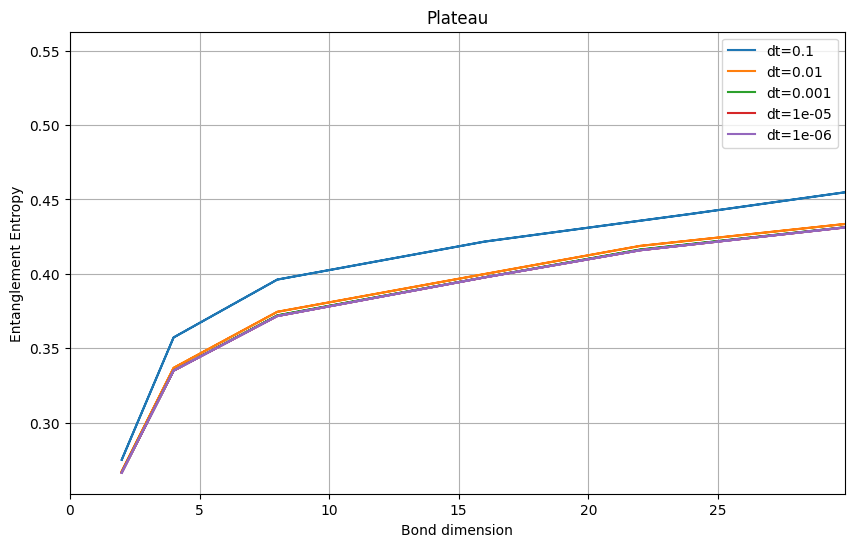

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Your data
data_y =b
data_x = d
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

for dt_value, y_values, x_values in zip([0.1, 0.01, 0.001, 1.e-5, 1.e-6], data_y, data_x):
    y = y_values[0]
    x = x_values[0]
    plt.plot(x, y, label="dt=" + str(dt_value))

plt.xlabel("Bond dimension")
plt.xlim(0,29.9)
plt.ylabel("Entanglement Entropy")
plt.title("Plateau")
plt.legend()
plt.grid(True)
plt.savefig("plateau",dpi=400)
plt.show()

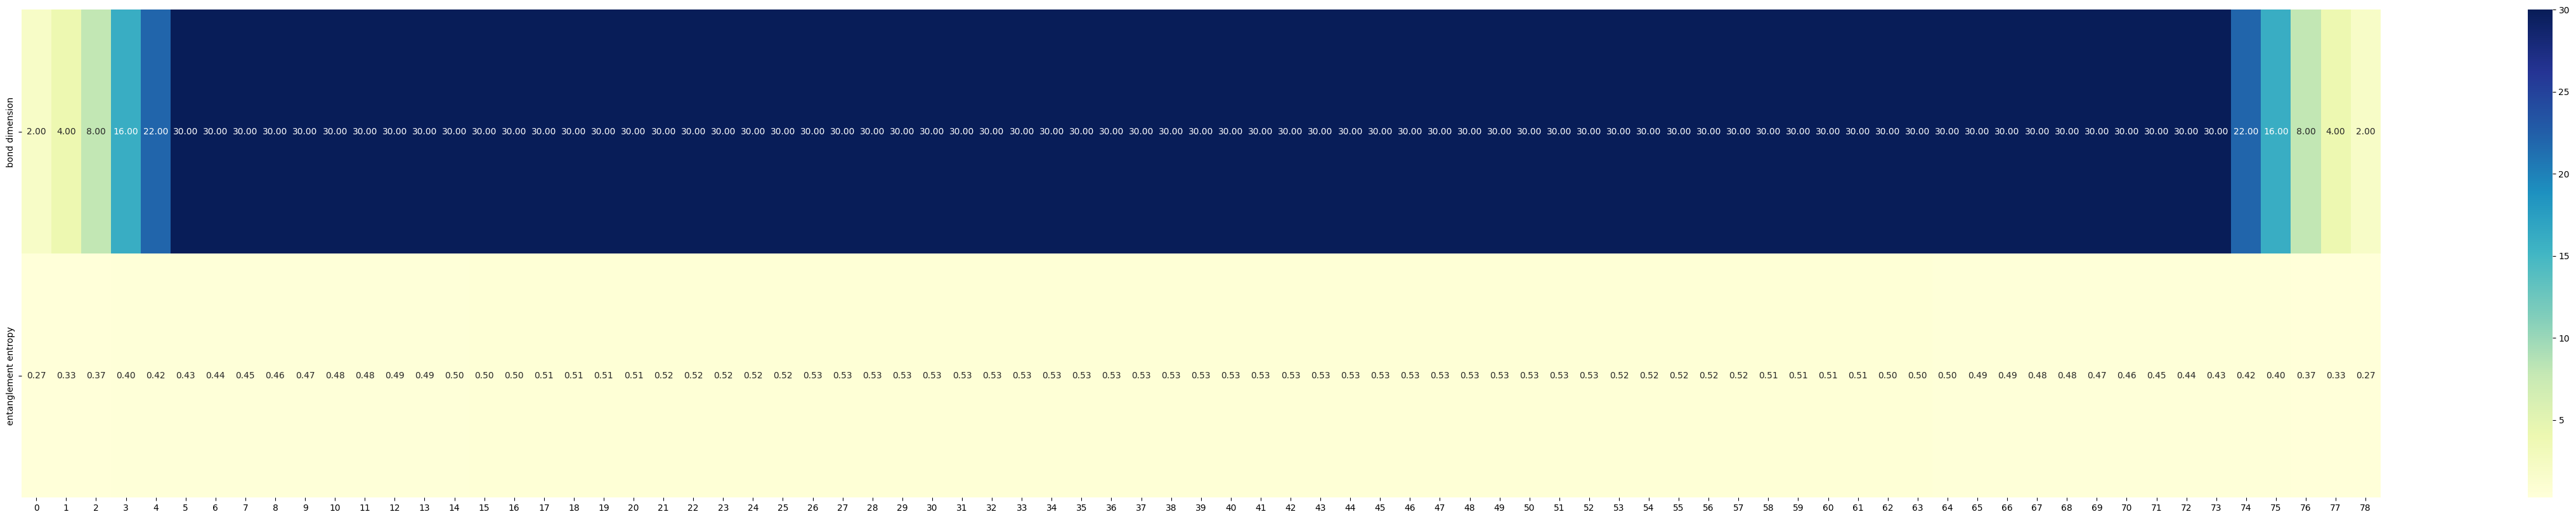

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (60,10)
# Sample data (replace with your actual arrays)
array1 = np.array(c)
array2 = np.array(b)

# Reshape arrays to 2D for heatmap
data = np.vstack([array1, array2])
y_labels = ['bond dimension', 'entanglement entropy']
# Create heatmap
sns.heatmap(data, cmap="YlGnBu" ,annot=True, fmt=".2f", cbar=True,yticklabels=y_labels)

# Display the plot
plt.savefig("plot_entropy_dim",dpi=500)
plt.show()

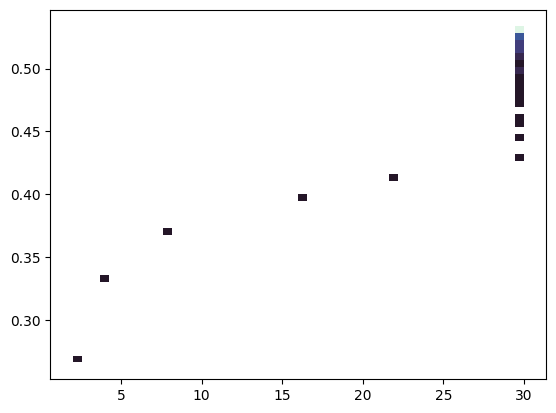

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'c' and 'b' are your data arrays
sns.histplot(x=c, y=b, bins=50, cmap="mako")
plt.show()

In [ ]:
def example_TEBD_gs_tf_ising_finite_new(L, g, chi_max=30):
    sigmaz = np.array([[1., 0.], [0., -1.]])
    print("finite TEBD, imaginary time evolution, transverse field Ising")
    print("L={L:d}, g={g:.2f}".format(L=L, g=g))
    # from . import a_mps
    # from . import b_model
    model =TFIModel(L=L, J=1., g=g, bc='finite')
    psi = init_FM_MPS(model.L, model.d, model.bc)
    for dt in [0.1,0.01,0.001,1.e-5,1.e-6]:
        U_bonds = calc_U_bonds(model.H_bonds, dt)
        run_TEBD(psi, U_bonds, N_steps=500, chi_max=chi_max, eps=1.e-10)
        E = np.sum(psi.bond_expectation_value(model.H_bonds))
        print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
    print("final bond dimensions: ", psi.get_chi())
    mag_x = np.sum(psi.site_expectation_value(model.sigmax))
    mag_z = np.sum(psi.site_expectation_value(model.sigmaz))
    print("magnetization in X = {mag_x:.5f}".format(mag_x=mag_x))
    print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))
    print("entanglement entropy = ", psi.entanglement_entropy())
    # print("correlation length = ", psi.correlation_length())
    return psi.correlation_function(sigmaz,5,sigmaz,6)

In [ ]:
d=example_TEBD_gs_tf_ising_finite_new(L=10, g=1.0)

finite TEBD, imaginary time evolution, transverse field Ising
L=10, g=1.00
dt = 0.10000: E = -12.3446865032241
dt = 0.01000: E = -12.3780979960037
dt = 0.00100: E = -12.3811510623369
dt = 0.00001: E = -12.3814828533779
dt = 0.00000: E = -12.3814858870182
final bond dimensions:  [2, 4, 8, 14, 19, 14, 8, 4, 2]
magnetization in X = 7.32203
magnetization in Z = 0.00000
entanglement entropy =  [0.26477662 0.32928594 0.35902351 0.37479477 0.37874558 0.37479477
 0.35902351 0.32928594 0.26477662]


**` Calculation for correlation-function`**


In [ ]:
L=[20,30,40,50,60,70,80]
d_new=[0 for i in range(len(L))]
for i,j in enumerate(L):
  d_new[i]=example_TEBD_gs_tf_ising_finite_new(L=j,g=1.0)

finite TEBD, imaginary time evolution, transverse field Ising
L=20, g=1.00
dt = 0.10000: E = -25.0240019422912
dt = 0.01000: E = -25.0998296428180
dt = 0.00100: E = -25.1069989866037
dt = 0.00001: E = -25.1077812775152
dt = 0.00000: E = -25.1077884264095
final bond dimensions:  [2, 4, 8, 16, 22, 27, 30, 30, 30, 30, 30, 30, 30, 27, 22, 16, 8, 4, 2]
magnetization in X = 13.89870
magnetization in Z = 0.00584
entanglement entropy =  [0.26699289 0.33557499 0.37160669 0.39625229 0.41244379 0.42518688
 0.43317655 0.43957401 0.44230413 0.44400456 0.44230413 0.43957401
 0.43317655 0.42518688 0.41244379 0.39625229 0.37160669 0.33557499
 0.26699289]
finite TEBD, imaginary time evolution, transverse field Ising
L=30, g=1.00
dt = 0.10000: E = -37.7094313205859
dt = 0.01000: E = -37.8257594734778
dt = 0.00100: E = -37.8368597334441
dt = 0.00001: E = -37.8380722379378
dt = 0.00000: E = -37.8380833167063
final bond dimensions:  [2, 4, 8, 16, 22, 28, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 

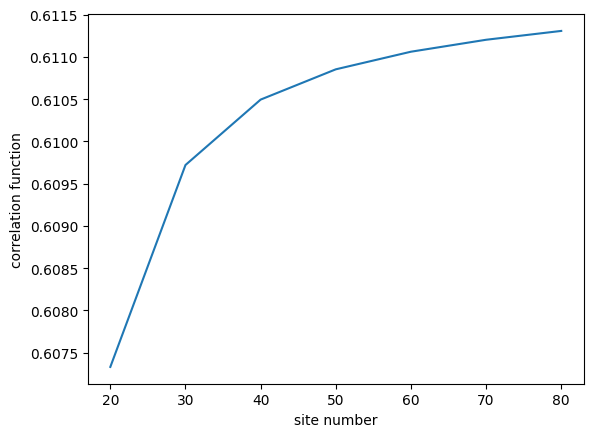

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("site number")
plt.ylabel("correlation function")
plt.plot(L,d_new)

**Calculation for magnetization m^2**

In [ ]:
def example_TEBD_gs_tf_ising_finite_new(L, g, chi_max=30):
    sigmaz = np.array([[1., 0.], [0., -1.]])
    print("finite TEBD, imaginary time evolution, transverse field Ising")
    print("L={L:d}, g={g:.2f}".format(L=L, g=g))
    # from . import a_mps
    # from . import b_model
    model =TFIModel(L=L, J=1., g=g, bc='finite')
    psi = init_FM_MPS(model.L, model.d, model.bc)
    for dt in [10e-3,2*10e-3,3*10e-3]:
        U_bonds = calc_U_bonds(model.H_bonds, dt)
        run_TEBD(psi, U_bonds, N_steps=500, chi_max=chi_max, eps=1.e-10)
        E = np.sum(psi.bond_expectation_value(model.H_bonds))
        print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
    print("final bond dimensions: ", psi.get_chi())
    mag_x = np.sum(psi.site_expectation_value(model.sigmax))
    mag_z = np.sum(psi.site_expectation_value(model.sigmaz))
    print("magnetization in X = {mag_x:.5f}".format(mag_x=mag_x))
    print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))
    print("entanglement entropy = ", psi.entanglement_entropy())
    # print("correlation length = ", psi.correlation_length())
    return psi.correlation_function(sigmaz,5,sigmaz,6)
L=[20,30,40,50,60,70,80]
d_new=[0 for i in range(len(L))]
for i,j in enumerate(L):
  d_new[i]=example_TEBD_gs_tf_ising_finite_new(L=j,g=1.0)

finite TEBD, imaginary time evolution, transverse field Ising
L=20, g=1.00
dt = 0.01000: E = -25.0547086583914
dt = 0.02000: E = -25.0890490835086
dt = 0.03000: E = -25.0836107214767
final bond dimensions:  [2, 4, 8, 16, 22, 25, 27, 29, 30, 30, 30, 29, 27, 25, 22, 16, 8, 4, 2]
magnetization in X = 13.82158
magnetization in Z = 0.32022
entanglement entropy =  [0.26999787 0.34259476 0.3801188  0.40444489 0.42150634 0.43378261
 0.44251159 0.44838042 0.45176868 0.45287924 0.45176868 0.44838042
 0.44251159 0.43378261 0.42150634 0.40444489 0.3801188  0.34259476
 0.26999787]
finite TEBD, imaginary time evolution, transverse field Ising
L=30, g=1.00
dt = 0.01000: E = -37.7781595784284
dt = 0.02000: E = -37.8057320694221
dt = 0.03000: E = -37.8004213367630
final bond dimensions:  [2, 4, 8, 16, 22, 27, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 29, 27, 22, 16, 8, 4, 2]
magnetization in X = 20.27378
magnetization in Z = 2.05148
entanglement entropy =  [0.26971132 0.34247609 0

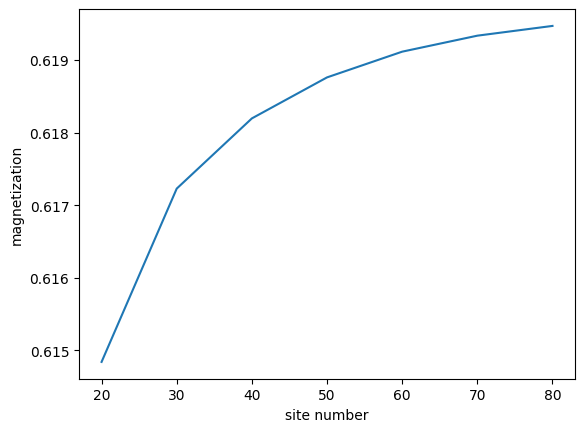

In [ ]:
plt.xlabel("site number")
plt.ylabel("magnetization")
plt.plot(L,d_new)

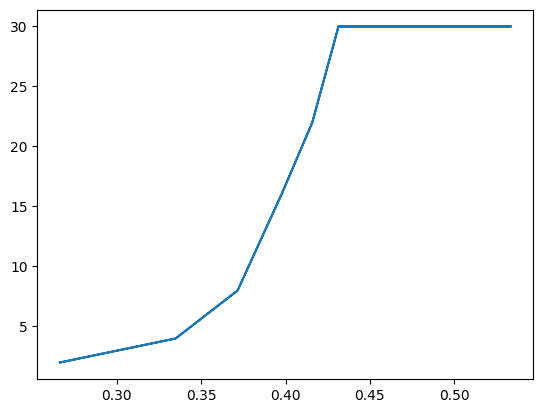

In [ ]:
d=[[],[]]
for i in range(len(b)):
  d[1].append(b[i])
plt.plot(d[1],c)

In [ ]:
len(c)

79

In [ ]:
import matplotlib.pyplot as plt
d1=[[],[]]
site_ar=[50,90]
for i in site_ar:
  for j in range(len(site_ar)):
    a,b1,c=example_TEBD_gs_tf_ising_finite(L=i, g=1.0);
    r=np.arange(len(b1))
    for c1 in range(len(b1)):
      d1[j].append(b1[c1])
# plt.plot(b1,r,label="L="+str(i))
# plt.legend()
# plt.show()

finite TEBD, imaginary time evolution, transverse field Ising
L=50, g=1.00
dt = 0.10000: E = -63.0845449543752
dt = 0.01000: E = -63.2801886929551
dt = 0.00100: E = -63.2989913135979
dt = 0.00001: E = -63.3010462288065
dt = 0.00000: E = -63.3010650076903
final bond dimensions:  [2, 4, 8, 16, 22, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 22, 16, 8, 4, 2]
magnetization in X = 33.28715
magnetization in Z = 2.02935
entanglement entropy =  [0.26744973 0.33702866 0.37462477 0.40141034 0.42037296 0.43652766
 0.44866532 0.45996603 0.46851003 0.47698003 0.4832603  0.48983589
 0.49452329 0.49970984 0.50318559 0.5072825  0.50977953 0.51297425
 0.51464045 0.51705308 0.5179828  0.51968911 0.51993976 0.52098348
 0.52058431 0.52098348 0.51993976 0.51968911 0.5179828  0.51705308
 0.51464045 0.51297425 0.50977953 0.5072825  0.50318559 0.49970984
 0.49452329 0.48983589 0.4832603  0.47698003 

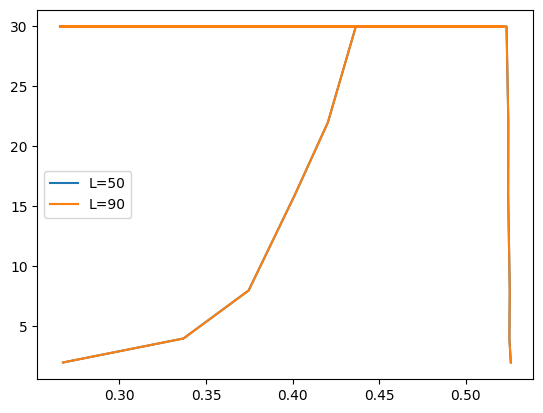

In [ ]:
for i in range(2):
  plt.plot(d1[i][0:89],c,label="L="+str(site_ar[i]))
plt.legend()
plt.show()

<Axes: >

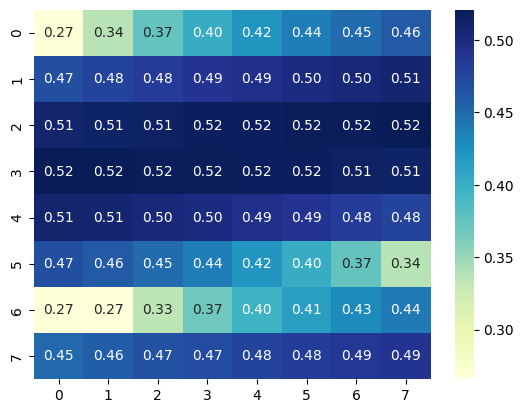

In [ ]:
import seaborn as sns
sns.heatmap(np.reshape(d1[1][0:64],(8,8)), cmap="YlGnBu", annot=True, fmt=".2f", cbar=True)

<Axes: >

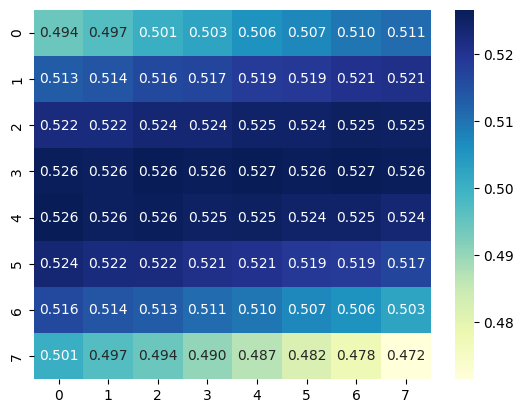

In [ ]:
import seaborn as sns
sns.heatmap(np.reshape(d1[0][64:128],(8,8)), cmap="YlGnBu", annot=True, fmt=".3f", cbar=True)

#**Suzuki Trotter Decomposition**
* **First Order**

In [ ]:
!pip install ncon
# from ncon import ncon

In [ ]:

import numpy as np


class TFIModel:

    def __init__(self, L, J, g, bc='finite'):
        assert bc in ['finite', 'infinite']
        self.L, self.d, self.bc = L, 2, bc
        self.J, self.g = J, g
        self.sigmax = np.array([[0., 1.], [1., 0.]])
        self.sigmay = np.array([[0., -1j], [1j, 0.]])
        self.sigmaz = np.array([[1., 0.], [0., -1.]])
        self.id = np.eye(2)
        self.init_H_bonds()
        self.init_H_mpo()
        self.init_H_bonds_1()
        self.init_H_bonds_2()

    def init_H_bonds_1(self):
      Z=self.sigmaz
      d = self.d
      nbonds = self.L - 1 if self.bc == 'finite' else self.L
      H_list = []
      H_bond1=-self.J * np.kron(Z, Z)
      H_list.append(np.reshape(H_bond1, [d, d, d, d]))
      self.H_bonds_1 = H_list
    def init_H_bonds_2(self):
      X=self.sigmax
      d = self.d
      nbonds = self.L - 1 if self.bc == 'finite' else self.L
      H_list = []
      for i in range(nbonds):
        gL = gR = 0.5 * self.g
        if self.bc == 'finite':
          if i == 0:
            gL = self.g
            if i + 1 == self.L - 1:
              gR = self.g
        H_bond2=-gL*np.kron(X,self.id)-gR*np.kron(self.id,X)
        H_list.append(np.reshape(H_bond2, [d, d, d, d]))
      self.H_bonds_2 = H_list
    def init_H_bonds(self):

        X, Z, Id = self.sigmax, self.sigmaz, self.id
        d = self.d
        nbonds = self.L - 1 if self.bc == 'finite' else self.L
        H_list = []
        for i in range(nbonds):
            gL = gR = 0.5 * self.g
            if self.bc == 'finite':
                if i == 0:
                    gL = self.g
                if i + 1 == self.L - 1:
                    gR = self.g
            H_bond = -self.J * np.kron(Z, Z) - gL * np.kron(X, Id) - gR * np.kron(Id, X)
            # note: kron is short-hand for outer product + grouping bra and ket legs.
            # H_bond has legs ``i, j, i*, j*``
            H_list.append(np.reshape(H_bond, [d, d, d, d]))
        self.H_bonds = H_list

    # (note: not required for TEBD)
    def init_H_mpo(self):

        w_list = []
        for i in range(self.L):
            w = np.zeros((3, 3, self.d, self.d), dtype=float)
            w[0, 0] = w[2, 2] = self.id
            w[0, 1] = self.sigmaz
            w[0, 2] = -self.g * self.sigmax
            w[1, 2] = -self.J * self.sigmaz
            w_list.append(w)
        self.H_mpo = w_list


In [ ]:
# from ncon import ncon

import numpy as np
from scipy.linalg import expm
# from .a_mps import split_truncate_theta


import numpy as np
from scipy.linalg import expm

def calc_U_bonds(H_bonds1, H_bonds2, dt):
    """
    Calculates the time evolution operators for bonds.

    Args:
        H_bonds1: List of bond Hamiltonians for the first term.
        H_bonds2: List of bond Hamiltonians for the second term.
        dt: Time step.

    Returns:
        List of time evolution operators for bonds.
    """
    d = H_bonds1[0].shape[0]
    U_bonds = []
    for H in H_bonds1:  # Assume H_bonds1 has one element
        H = np.reshape(H, [d * d, d * d])
        U1 = expm(-dt * H)  # U1 for the first term

    # Modified: Loop through H_bonds2 to create the full list of U_bonds
    for j, H in enumerate(H_bonds2):
        H = np.reshape(H, [d * d, d * d])
        U2 = expm(-dt * H)  # U2 for the second term
    for H in H_bonds1:  # Assume H_bonds1 has one element
        H = np.reshape(H, [d * d, d * d])
        U3 = expm(-dt * H)  # U1 for the first term
    for j, H in enumerate(H_bonds2):
        H = np.reshape(H, [d * d, d * d])
        U4 = expm(-dt * H)  # U2 for the second term
    for H in H_bonds1:  # Assume H_bonds1 has one element
        H = np.reshape(H, [d * d, d * d])
        U5 = expm(-dt * H)  # U1 for the first term
    for j, H in enumerate(H_bonds2):
        H = np.reshape(H, [d * d, d * d])
        U6 = expm(-dt * H)  # U2 for the second term
        U_bonds.append(np.reshape(U1, [d, d, d, d]) * np.reshape(U2, [d, d, d, d])*np.reshape(U3, [d, d, d, d])*np.reshape(U4, [d, d, d, d])*np.reshape(U5, [d, d, d, d])*np.reshape(U6, [d, d, d, d]))

    return U_bonds

def run_TEBD(psi, U_bonds, N_steps, chi_max, eps):

    Nbonds = psi.L - 1 if psi.bc == 'finite' else psi.L
    assert len(U_bonds) == Nbonds
    for n in range(N_steps):
        for k in [0, 1]:  # even, odd
            for i_bond in range(k, Nbonds, 2):
                update_bond(psi, i_bond, U_bonds[i_bond], chi_max, eps)
    # done


def update_bond(psi, i, U_bond, chi_max, eps):

    j = (i + 1) % psi.L
    # construct theta matrix
    theta = psi.get_theta2(i)  # vL i j vR
    # apply U
    Utheta = np.tensordot(U_bond, theta, axes=([2, 3], [1, 2]))  # i j [i*] [j*], vL [i] [j] vR
    Utheta = np.transpose(Utheta, [2, 0, 1, 3])  # vL i j vR
    # split and truncate
    Ai, Sj, Bj = split_truncate_theta(Utheta, chi_max, eps)
    # put back into MPS
    Gi = np.tensordot(np.diag(psi.Ss[i]**(-1)), Ai, axes=(1, 0))  # vL [vL*], [vL] i vC
    psi.Bs[i] = np.tensordot(Gi, np.diag(Sj), axes=(2, 0))  # vL i [vC], [vC] vC
    psi.Ss[j] = Sj  # vC
    psi.Bs[j] = Bj  # vC j vR


def example_TEBD_gs_tf_ising_finite(L, g, chi_max=30):
    print("finite TEBD, imaginary time evolution, transverse field Ising")
    print("L={L:d}, g={g:.2f}".format(L=L, g=g))
    # from . import a_mps
    # from . import b_model
    model =TFIModel(L=L, J=1., g=g, bc='finite')
    psi = init_FM_MPS(model.L, model.d, model.bc)
    for dt in [10e-3,2*10e-3,3*10e-3]:
        U_bonds = calc_U_bonds(model.H_bonds_1,model.H_bonds_2, dt)
        run_TEBD(psi, U_bonds, N_steps=500, chi_max=chi_max, eps=1.e-10)
        E = np.sum(psi.bond_expectation_value(model.H_bonds))
        print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
    print("final bond dimensions: ", psi.get_chi())
    mag_x = np.sum(psi.site_expectation_value(model.sigmax))
    mag_z = np.sum(psi.site_expectation_value(model.sigmaz))
    print("magnetization in X = {mag_x:.5f}".format(mag_x=mag_x))
    print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))
    print("entanglement entropy = ", psi.entanglement_entropy())
    # print("correlation length = ", psi.correlation_length())
    return E, psi.entanglement_entropy(), psi.get_chi()


a,b,c=example_TEBD_gs_tf_ising_finite(L=80, g=1.0)

finite TEBD, imaginary time evolution, transverse field Ising
L=80, g=1.00
dt = 0.01000: E = -79.0000000000000
dt = 0.02000: E = -79.0000000000000
dt = 0.03000: E = -79.0000000000000
final bond dimensions:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
magnetization in X = 0.00000
magnetization in Z = 80.00000
entanglement entropy =  [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0.]


In [ ]:
b_reshaped=b.reshape(len(b),-1)
pl.pcolor(b_reshaped,cmap="jet")
pl.show()

#**Trotter Decomposition**
* **Second order**

In [ ]:
# from ncon import ncon

import numpy as np
from scipy.linalg import expm
# from .a_mps import split_truncate_theta


import numpy as np
from scipy.linalg import expm

def calc_U_bonds(H_bonds1, H_bonds2, dt):
    """
    Calculates the time evolution operators for bonds.

    Args:
        H_bonds1: List of bond Hamiltonians for the first term.
        H_bonds2: List of bond Hamiltonians for the second term.
        dt: Time step.

    Returns:
        List of time evolution operators for bonds.
    """
    d = H_bonds1[0].shape[0]
    U_bonds = []
    for H in H_bonds1:  # Assume H_bonds1 has one element
        H = np.reshape(H, [d * d, d * d])
        U1 = expm(-dt/2 * H)  # U1 for the first term

    # Modified: Loop through H_bonds2 to create the full list of U_bonds
    for j, H in enumerate(H_bonds2):
        H = np.reshape(H, [d * d, d * d])
        U2 = expm(-dt * H)  # U2 for the second term
    for H in H_bonds1:  # Assume H_bonds1 has one element
        H = np.reshape(H, [d * d, d * d])
        U3 = expm(-dt/2 * H)  # U1 for the first term
    for j, H in enumerate(H_bonds2):
        H = np.reshape(H, [d * d, d * d])
        U4 = expm(-dt/2 * H)  # U2 for the second term
    for H in H_bonds1:  # Assume H_bonds1 has one element
        H = np.reshape(H, [d * d, d * d])
        U5 = expm(-dt * H)  # U1 for the first term
    for j, H in enumerate(H_bonds2):
        H = np.reshape(H, [d * d, d * d])
        U6 = expm(-dt/2 * H)  # U2 for the second term
        U_bonds.append(np.reshape(U1, [d, d, d, d]) * np.reshape(U2, [d, d, d, d])*np.reshape(U3, [d, d, d, d])*np.reshape(U4, [d, d, d, d])*np.reshape(U5, [d, d, d, d])*np.reshape(U6, [d, d, d, d]))

    return U_bonds

def run_TEBD(psi, U_bonds, N_steps, chi_max, eps):

    Nbonds = psi.L - 1 if psi.bc == 'finite' else psi.L
    assert len(U_bonds) == Nbonds
    for n in range(N_steps):
        for k in [0, 1]:  # even, odd
            for i_bond in range(k, Nbonds, 2):
                update_bond(psi, i_bond, U_bonds[i_bond], chi_max, eps)
    # done


def update_bond(psi, i, U_bond, chi_max, eps):

    j = (i + 1) % psi.L
    # construct theta matrix
    theta = psi.get_theta2(i)  # vL i j vR
    # apply U
    Utheta = np.tensordot(U_bond, theta, axes=([2, 3], [1, 2]))  # i j [i*] [j*], vL [i] [j] vR
    Utheta = np.transpose(Utheta, [2, 0, 1, 3])  # vL i j vR
    # split and truncate
    Ai, Sj, Bj = split_truncate_theta(Utheta, chi_max, eps)
    # put back into MPS
    Gi = np.tensordot(np.diag(psi.Ss[i]**(-1)), Ai, axes=(1, 0))  # vL [vL*], [vL] i vC
    psi.Bs[i] = np.tensordot(Gi, np.diag(Sj), axes=(2, 0))  # vL i [vC], [vC] vC
    psi.Ss[j] = Sj  # vC
    psi.Bs[j] = Bj  # vC j vR


def example_TEBD_gs_tf_ising_finite(L, g, chi_max=30):
    print("finite TEBD, imaginary time evolution, transverse field Ising")
    print("L={L:d}, g={g:.2f}".format(L=L, g=g))
    # from . import a_mps
    # from . import b_model
    model =TFIModel(L=L, J=1., g=g, bc='finite')
    psi = init_FM_MPS(model.L, model.d, model.bc)
    for dt in [0.1,0.01,0.001,1.e-5,1.e-6]:
        U_bonds = calc_U_bonds(model.H_bonds_1,model.H_bonds_2, dt)
        run_TEBD(psi, U_bonds, N_steps=500, chi_max=chi_max, eps=1.e-10)
        E = np.sum(psi.bond_expectation_value(model.H_bonds))
        print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
    print("final bond dimensions: ", psi.get_chi())
    mag_x = np.sum(psi.site_expectation_value(model.sigmax))
    mag_z = np.sum(psi.site_expectation_value(model.sigmaz))
    print("magnetization in X = {mag_x:.5f}".format(mag_x=mag_x))
    print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))
    print("entanglement entropy = ", psi.entanglement_entropy())
    # print("correlation length = ", psi.correlation_length())
    return E, psi.entanglement_entropy(), psi.get_chi()


a,b,c=example_TEBD_gs_tf_ising_finite(L=80, g=1.0)

finite TEBD, imaginary time evolution, transverse field Ising
L=80, g=1.00
dt = 0.10000: E = -79.0000000000000
dt = 0.01000: E = -79.0000000000000
dt = 0.00100: E = -79.0000000000000
dt = 0.00001: E = -79.0000000000000
dt = 0.00000: E = -79.0000000000000
final bond dimensions:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
magnetization in X = 0.00000
magnetization in Z = 80.00000
entanglement entropy =  [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0.]


#**Transverse Longitudinal ising Model**
* **Entanglement Entropy**

In [ ]:
import pylab as pl
import numpy as np
from scipy.linalg import svd

In [ ]:
# Example with two lists
list1 = [1, 2, 3]
list2 = [4, 5, 6]

zipped = zip(list1, list2)
emp=[]
zipped_list = list(zipped)
for i in range(len(zipped_list)):
  emp.append(zipped_list[i][0] + zipped_list[i][1])
emp

[5, 7, 9]

# **Transverse and Longitudinal field ising model**

In [ ]:
import numpy as np
from scipy.linalg import svd
class SimpleMPS:


    def __init__(self, Bs, Ss, bc='finite'):
        assert bc in ['finite', 'infinite']
        self.Bs = Bs
        self.Ss = Ss
        self.bc = bc
        self.L = len(Bs)
        self.nbonds = self.L - 1 if self.bc == 'finite' else self.L

    def copy(self):
        return SimpleMPS([B.copy() for B in self.Bs], [S.copy() for S in self.Ss], self.bc)

    def get_theta1(self, i):

        return np.tensordot(np.diag(self.Ss[i]), self.Bs[i], [1, 0])  # vL [vL'], [vL] i vR

    def get_theta2(self, i):

        j = (i + 1) % self.L
        return np.tensordot(self.get_theta1(i), self.Bs[j], [2, 0])  # vL i [vR], [vL] j vR

    def get_chi(self):

        return [self.Bs[i].shape[2] for i in range(self.nbonds)]

    def site_expectation_value(self, op):

        result = []
        for i in range(self.L):
            theta = self.get_theta1(i)  # vL i vR
            op_theta = np.tensordot(op, theta, axes=(1, 1))  # i [i*], vL [i] vR
            result.append(np.tensordot(theta.conj(), op_theta, [[0, 1, 2], [1, 0, 2]]))
            # [vL*] [i*] [vR*], [i] [vL] [vR]
        return np.real_if_close(result)

    def bond_expectation_value(self, op):

        result = []
        for i in range(self.nbonds):
            theta = self.get_theta2(i)  # vL i j vR
            op_theta = np.tensordot(op[i], theta, axes=([2, 3], [1, 2]))
            # i j [i*] [j*], vL [i] [j] vR
            result.append(np.tensordot(theta.conj(), op_theta, [[0, 1, 2, 3], [2, 0, 1, 3]]))
            # [vL*] [i*] [j*] [vR*], [i] [j] [vL] [vR]
        return np.real_if_close(result)

    def entanglement_entropy(self):

        bonds = range(1, self.L) if self.bc == 'finite' else range(0, self.L)
        result = []
        for i in bonds:
            S = self.Ss[i]
            S = S[S > 1.e-20]  # 0*log(0) should give 0 and won't contribute to the sum
            # avoid warning or NaN by discarding the very small values of S
            S2 = S * S
            assert abs(np.linalg.norm(S) - 1.) < 1.e-13
            result.append(-np.sum(S2 * np.log(S2)))
        return np.array(result)

    def correlation_length(self):
        from scipy.sparse.linalg import eigs
        if self.get_chi()[0] > 100:
            warnings.warn("Skip calculating correlation_length() for large chi: could take long")
            return -1.
        assert self.bc == 'infinite'  # works only in the infinite case
        B = self.Bs[0]  # vL i vR
        chi = B.shape[0]
        T = np.tensordot(B, np.conj(B), axes=(1, 1))  # vL [i] vR, vL* [i*] vR*
        T = np.transpose(T, [0, 2, 1, 3])  # vL vL* vR vR*
        for i in range(1, self.L):
            B = self.Bs[i]
            T = np.tensordot(T, B, axes=(2, 0))  # vL vL* [vR] vR*, [vL] i vR
            T = np.tensordot(T, np.conj(B), axes=([2, 3], [0, 1]))
            # vL vL* [vR*] [i] vR, [vL*] [i*] vR*
        T = np.reshape(T, (chi**2, chi**2))
        # Obtain the 2nd largest eigenvalue
        eta = eigs(T, k=2, which='LM', return_eigenvectors=False, ncv=20)
        xi =  -self.L / np.log(np.min(np.abs(eta)))
        if xi > 1000.:
            return np.inf
        return xi

    def correlation_function(self, op_i, i, op_j, j):
        # assert i < j
        theta = self.get_theta1(i) # vL i vR
        C = np.tensordot(op_i, theta, axes=(1, 1)) # i [i*], vL [i] vR
        C = np.tensordot(theta.conj(), C, axes=([0, 1], [1, 0]))  # [vL*] [i*] vR*, [i] [vL] vR
        for k in range(i + 1, j):
            k = k % self.L
            B = self.Bs[k]  # vL k vR
            C = np.tensordot(C, B, axes=(1, 0)) # vR* [vR], [vL] k vR
            C = np.tensordot(B.conj(), C, axes=([0, 1], [0, 1])) # [vL*] [k*] vR*, [vR*] [k] vR
        j = j % self.L
        B = self.Bs[j]  # vL k vR
        C = np.tensordot(C, B, axes=(1, 0)) # vR* [vR], [vL] j vR
        C = np.tensordot(op_j, C, axes=(1, 1))  # j [j*], vR* [j] vR
        C = np.tensordot(B.conj(), C, axes=([0, 1, 2], [1, 0, 2])) # [vL*] [j*] [vR*], [j] [vR*] [vR]
        return C


def init_FM_MPS(L, d=2, bc='finite'):

    B = np.zeros([1, d, 1], dtype=float)
    B[0, 0, 0] = 1.
    S = np.ones([1], dtype=float)
    Bs = [B.copy() for i in range(L)]
    Ss = [S.copy() for i in range(L)]
    return SimpleMPS(Bs, Ss, bc=bc)


def init_Neel_MPS(L, d=2, bc='finite'):

    S = np.ones([1], dtype=float)
    Bs = []
    for i in range(L):
        B = np.zeros([1, d, 1], dtype=float)
        if i % 2 == 0:
            B[0, 0, 0] = 1.
        else:
            B[0, -1, 0] = 1.
        Bs.append(B)
    Ss = [S.copy() for i in range(L)]
    return SimpleMPS(Bs, Ss, bc=bc)


def split_truncate_theta(theta, chi_max, eps):

    chivL, dL, dR, chivR = theta.shape
    theta = np.reshape(theta, [chivL * dL, dR * chivR])
    X, Y, Z = svd(theta, full_matrices=False)
    # truncate
    chivC = min(chi_max, np.sum(Y > eps))
    assert chivC >= 1
    piv = np.argsort(Y)[::-1][:chivC]  # keep the largest `chivC` singular values
    X, Y, Z = X[:, piv], Y[piv], Z[piv, :]
    # renormalize
    S = Y / np.linalg.norm(Y)  # == Y/sqrt(sum(Y**2))
    # split legs of X and Z
    A = np.reshape(X, [chivL, dL, chivC])
    B = np.reshape(Z, [chivC, dR, chivR])
    return A, S, B


In [74]:
class TLFIModel:
  def __init__(self,L,J,hs,hz,bc='finite'):
    assert bc in ['finite','infinite']
    self.L,self.d,self.bc = L,2,bc
    self.J= J
    self.hs = hs
    self.hz = hz
    self.sigmax = np.array([[0. ,1. ],[1. ,0. ]],)
    self.sigmay = np.array([[0. ,-1j],[1j , 0.]])
    self.sigmaz = np.array([[1. ,0. ],[0. ,-1. ]])
    self.id = np.eye(2) # define id as np.eye(2)
    self.init_H_bonds()
    self.init_H_MPO()
  def init_H_bonds(self):
    sx,sy,sz = self.sigmax,self.sigmay,self.sigmaz
    d = self.d
    nbonds = self.L -1 if self.bc == 'finite' else self.L
    H_list=[]
    for i in range(nbonds):
      hl=hr=0.5*self.hs
      hl1=hr1=0.5*self.hz
      if self.bc == 'finite':
        if i == 0:
          hl=self.hs
        if i+1 == self.L-1:
          hr=self.hs
      H_bond = -self.J * np.kron(sx,sx)
      # Use self.id instead of id
      H_bond = H_bond - hl*(-1)**i * np.kron(sz,self.id) + hr*(-1)**(i+1) * np.kron(self.id,sz) - hl1*(-1)**i * np.kron(sx,self.id) + hr1*(-1)**(i+1) * np.kron(self.id,sx)
      H_list.append(np.reshape(H_bond,[d,d,d,d]))
    self.H_bonds = H_list
  def init_H_MPO(self):
    w_list = []
    for i in range(self.L):
      w=np.zeros((3,3, self.d ,self.d),dtype = float)
      w[0,0]=w[2,2]=self.id
      w[0,1]= self.sigmaz
      w[0,2]= -self.hs*self.sigmaz-self.hz*self.sigmax
      w[1,2]= -self.J*self.sigmaz
      w_list.append(w)
    self.H_MPO = w_list

In [ ]:
import numpy as np
from scipy.linalg import expm
# from .a_mps import split_truncate_theta


def calc_U_bonds(H_bonds, dt):

    d = H_bonds[0].shape[0]
    U_bonds = []
    for H in H_bonds:
        H = np.reshape(H, [d * d, d * d])
        U = expm(-dt * H)
        U_bonds.append(np.reshape(U, [d, d, d, d]))
    return U_bonds


def run_TEBD(psi, U_bonds, N_steps, chi_max, eps):

    Nbonds = psi.L - 1 if psi.bc == 'finite' else psi.L
    assert len(U_bonds) == Nbonds
    for n in range(N_steps):
        for k in [0, 1]:  # even, odd
            for i_bond in range(k, Nbonds, 2):
                update_bond(psi, i_bond, U_bonds[i_bond], chi_max, eps)
    # done


def update_bond(psi, i, U_bond, chi_max, eps):

    j = (i + 1) % psi.L
    # construct theta matrix
    theta = psi.get_theta2(i)  # vL i j vR
    # apply U
    Utheta = np.tensordot(U_bond, theta, axes=([2, 3], [1, 2]))  # i j [i*] [j*], vL [i] [j] vR
    Utheta = np.transpose(Utheta, [2, 0, 1, 3])  # vL i j vR
    # split and truncate
    Ai, Sj, Bj = split_truncate_theta(Utheta, chi_max, eps)
    # put back into MPS
    Gi = np.tensordot(np.diag(psi.Ss[i]**(-1)), Ai, axes=(1, 0))  # vL [vL*], [vL] i vC
    psi.Bs[i] = np.tensordot(Gi, np.diag(Sj), axes=(2, 0))  # vL i [vC], [vC] vC
    psi.Ss[j] = Sj  # vC
    psi.Bs[j] = Bj  # vC j vR


def example_TEBD_gs_tf_ising_finite(L, g, chi_max=30):
    print("finite TEBD, imaginary time evolution, transverse field Ising")
    print("L={L:d}, g={g:.2f}".format(L=L, g=g))
    # from . import a_mps
    # from . import b_model
    model =TLFIModel(L=L, J=1., hs=g,hz=0.5, bc='finite')
    psi = init_FM_MPS(model.L, model.d, model.bc)
    for dt in [0.1,0.01,0.001,1.e-5,1.e-6]:
        U_bonds = calc_U_bonds(model.H_bonds, dt)
        run_TEBD(psi, U_bonds, N_steps=500, chi_max=chi_max, eps=1.e-10)
        E = np.sum(psi.bond_expectation_value(model.H_bonds))
        print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
    print("final bond dimensions: ", psi.get_chi())
    mag_x = np.sum(psi.site_expectation_value(model.sigmax))
    mag_z = np.sum(psi.site_expectation_value(model.sigmaz))
    print("magnetization in X = {mag_x:.5f}".format(mag_x=mag_x))
    print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))
    print("entanglement entropy = ", psi.entanglement_entropy())
    # print("correlation length = ", psi.correlation_length())
    return E, psi.entanglement_entropy(), psi.get_chi()

In [ ]:
a,b,c=example_TEBD_gs_tf_ising_finite(L=30, g=1.0)

finite TEBD, imaginary time evolution, transverse field Ising
L=30, g=1.00
dt = 0.10000: E = -30.1298680143277
dt = 0.01000: E = -30.2008647983207
dt = 0.00100: E = -30.2015269402416
dt = 0.00001: E = -30.2015283088023
dt = 0.00000: E = -30.2015284412151
final bond dimensions:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
magnetization in X = 29.56172
magnetization in Z = 1.21838
entanglement entropy =  [1.07234525e-06 9.04169717e-11 2.22425884e-11 2.27915506e-11
 2.22420455e-11 2.27915507e-11 2.22420456e-11 2.27915506e-11
 2.22420456e-11 2.27915504e-11 2.22420454e-11 2.27915502e-11
 2.22420453e-11 2.27915508e-11 2.22420455e-11 2.27915508e-11
 2.22420453e-11 2.27915507e-11 2.22420456e-11 2.27915506e-11
 2.22420455e-11 2.27915506e-11 2.22420455e-11 2.27915507e-11
 2.22420456e-11 2.27915504e-11 2.22425896e-11 9.04169710e-11
 1.07234525e-06]


In [ ]:
array1 = np.array(c)
array2 = np.array(b)
plt.rcParams['figure.figsize'] = [60, 15]
plt.rcParams['figure.dpi'] = 500
# Reshape arrays to 2D for heatmap
data = np.vstack([array1, array2])
y_labels = ['bond dimension', 'entanglement entropy']
# Create heatmap
sns.heatmap(data, cmap="YlGnBu" ,annot=True, fmt=".2e", cbar=True,yticklabels=y_labels)

# Display the plot
plt.savefig("plot_entropy_dim_new",dpi=500)
plt.show()

In [ ]:
data

array([[2.00000000e+00, 2.00000000e+00, 2.00000000e+00, 2.00000000e+00,
        2.00000000e+00, 2.00000000e+00, 2.00000000e+00, 2.00000000e+00,
        2.00000000e+00, 2.00000000e+00, 2.00000000e+00, 2.00000000e+00,
        2.00000000e+00, 2.00000000e+00, 2.00000000e+00, 2.00000000e+00,
        2.00000000e+00, 2.00000000e+00, 2.00000000e+00, 2.00000000e+00,
        2.00000000e+00, 2.00000000e+00, 2.00000000e+00, 2.00000000e+00,
        2.00000000e+00, 2.00000000e+00, 2.00000000e+00, 2.00000000e+00,
        2.00000000e+00],
       [1.07234525e-06, 9.04169717e-11, 2.22425884e-11, 2.27915506e-11,
        2.22420455e-11, 2.27915507e-11, 2.22420456e-11, 2.27915506e-11,
        2.22420456e-11, 2.27915504e-11, 2.22420454e-11, 2.27915502e-11,
        2.22420453e-11, 2.27915508e-11, 2.22420455e-11, 2.27915508e-11,
        2.22420453e-11, 2.27915507e-11, 2.22420456e-11, 2.27915506e-11,
        2.22420455e-11, 2.27915506e-11, 2.22420455e-11, 2.27915507e-11,
        2.22420456e-11, 2.27915504e-11,

In [ ]:
import numpy as np

import numpy as np

site_ar = [10,15,20,25,28,32,36,38,42,45,40]
# Initialize a_n as a list of empty arrays, each with shape (20, 1)
a_n = [np.empty((8, 1)) for _ in range(len(site_ar))]

for i in range(len(site_ar)):
    e, b, c = example_TEBD_gs_tf_ising_finite(L=site_ar[i], g=1.0)
    # Assume b is the array with 20 values that needs to be stored
    a_n[i][:, 0] = b[:8]  # Storing the first 20 values of b into the ith array in a_n

# Converting list of arrays into a single numpy array under a single column
a_n_combined = np.concatenate(a_n, axis=0)


finite TEBD, imaginary time evolution, transverse field Ising
L=10, g=1.00
dt = 0.10000: E = -10.1814999894312
dt = 0.01000: E = -10.2013668374354
dt = 0.00100: E = -10.2015516084937
dt = 0.00001: E = -10.2015519972341
dt = 0.00000: E = -10.2015520349691
final bond dimensions:  [2, 2, 2, 2, 2, 2, 2, 2, 2]
magnetization in X = 9.56173
magnetization in Z = 1.24010
entanglement entropy =  [1.07234525e-06 9.04169719e-11 2.22425886e-11 2.27915507e-11
 2.22420458e-11 2.27915505e-11 2.22425894e-11 9.04169708e-11
 1.07234525e-06]
finite TEBD, imaginary time evolution, transverse field Ising
L=15, g=1.00
dt = 0.10000: E = -14.7519908905990
dt = 0.01000: E = -14.8437604160109
dt = 0.00100: E = -14.8501001993737
dt = 0.00001: E = -14.8507581976796
dt = 0.00000: E = -14.8507642277807
final bond dimensions:  [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2]
magnetization in X = -5.17005
magnetization in Z = 0.04802
entanglement entropy =  [0.36651771 0.6270538  0.62705494 0.62705466 0.62705471 0.62705443


In [ ]:
a_sep=[np.empty((8, len(site_ar))) for _ in range(len(site_ar))]
for i in range(len(site_ar)):
  for j in range(8,8,len(a_n)):
    a_sep[i][:,j]=a_n_combined[j]

In [ ]:
for i in range(len(a_sep)):
  a_sep[i]=a_sep[i].flatten()

In [ ]:
for i in range(len(a_sep)):
  print(a_sep[i])

[5.03749644e-316 0.00000000e+000 3.30529917e-321             nan
 1.27802866e-152 3.32230396e+257 2.31881454e-152 3.68065909e+180
 9.82208445e+252 1.39806876e-152 1.27921601e-152 5.82659453e+252
 2.66052666e-260 2.76584663e+199 9.13612771e+242 2.32160957e-152
 2.31461375e-152 2.08111237e-115 1.90649549e+185 4.37339761e+257
 1.69592889e-152 2.42776664e-154 7.75444640e+228 1.91570156e+227
 5.04350391e+180 1.49001906e+195 6.19640467e+223 4.96042850e+180
 1.00838756e+261 4.95238678e+223 1.34452794e+161 1.51327986e+256
 1.95134824e+227 1.27989332e-152 5.83108779e+252 2.64626849e-260
 1.08613915e-153 1.72722582e+097 1.87673433e-152 5.28563039e+180
 6.01346953e-154 1.05908440e-153 5.03734573e+180 1.50370007e+161
 3.45121411e-085 6.01346953e-154 1.71898008e+161 1.15823459e-152
 9.08367206e+223 6.89975712e+212 1.72053730e+243 1.06186010e-153
 1.46921995e+195 1.11390684e-258 9.31464415e+242 1.68821600e+195
 3.80985005e+180 2.64684769e+180 2.34953944e+251 7.20535013e+159
 8.70446315e+183 1.387955

In [ ]:
for i in range(len(site_ar)):
  for j in range(8,8,len(a_n_combined)):
    print(i,j)

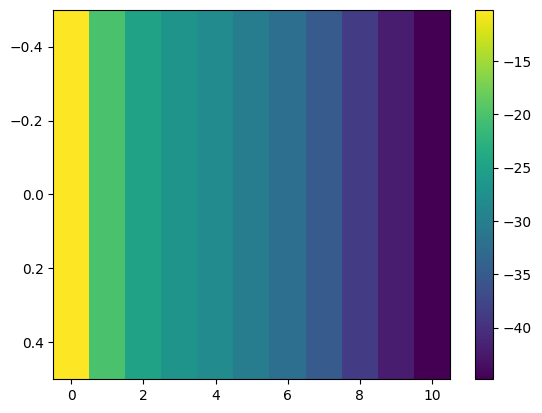

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
data = np.reshape(a_n,(1,-1))
plt.imshow(data,cmap='viridis',aspect='auto')
plt.colorbar()
plt.show()

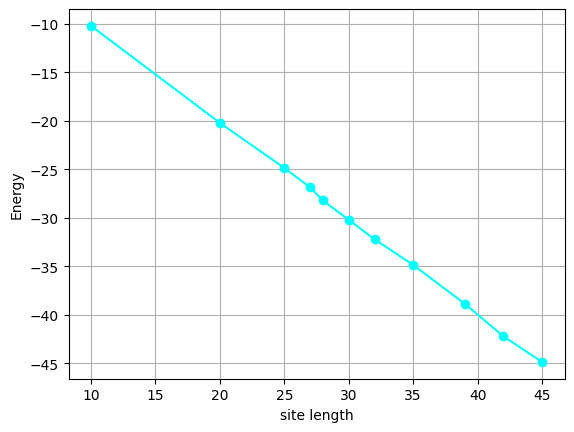

In [ ]:
plt.plot(site_ar,a_n,marker='o',linestyle='-',color='cyan')
plt.xlabel('site length')
plt.ylabel('Energy')
plt.grid()
plt.show()

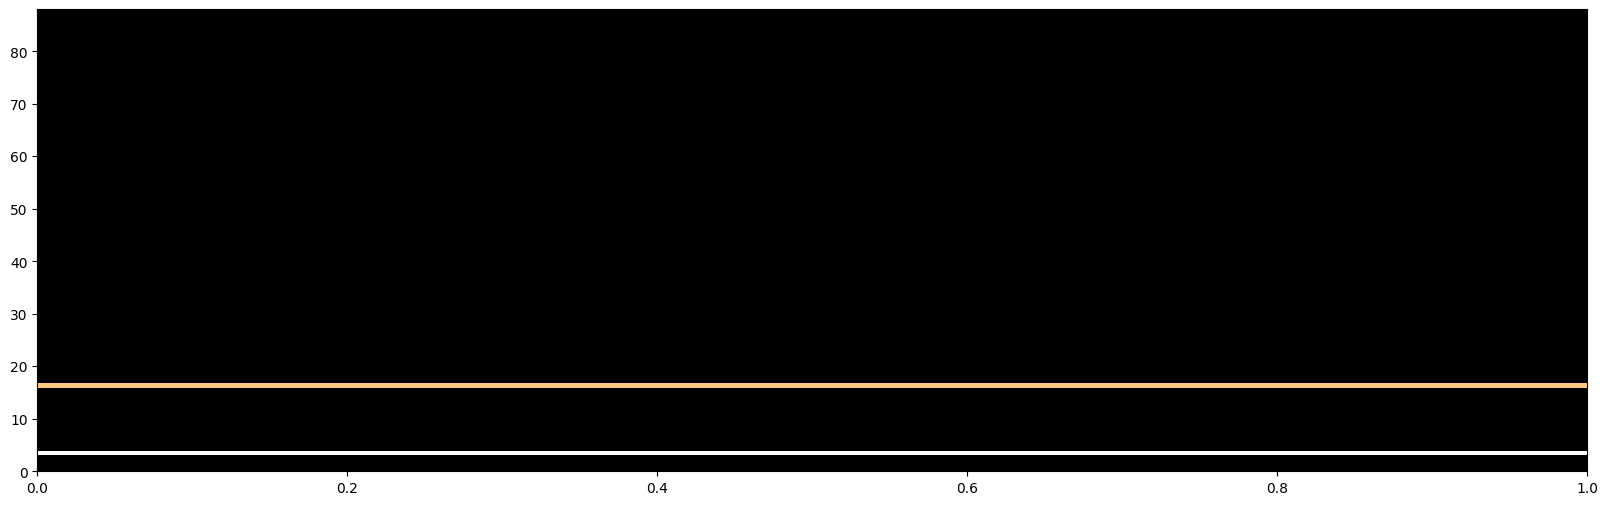

In [ ]:
b_reshaped=a_sep[1].reshape(len(a_sep[1]),-1)
pl.pcolor(b_reshaped,cmap="copper")
pl.show()

#**TLFI-Model**

In [ ]:


import numpy as np
from scipy.linalg import svd



class SimpleMPS:

    def __init__(self, Bs, Ss, bc='finite'):
        assert bc in ['finite', 'infinite']
        self.Bs = Bs
        self.Ss = Ss
        self.bc = bc
        self.L = len(Bs)
        self.nbonds = self.L - 1 if self.bc == 'finite' else self.L

    def copy(self):
        return SimpleMPS([B.copy() for B in self.Bs], [S.copy() for S in self.Ss], self.bc)

    def get_theta1(self, i):

        return np.tensordot(np.diag(self.Ss[i]), self.Bs[i], [1, 0])  # vL [vL'], [vL] i vR

    def get_theta2(self, i):

        j = (i + 1) % self.L
        return np.tensordot(self.get_theta1(i), self.Bs[j], [2, 0])  # vL i [vR], [vL] j vR

    def get_chi(self):

        return [self.Bs[i].shape[2] for i in range(self.nbonds)]

    def site_expectation_value(self, op):

        result = []
        for i in range(self.L):
            theta = self.get_theta1(i)  # vL i vR
            op_theta = np.tensordot(op, theta, axes=(1, 1))  # i [i*], vL [i] vR
            result.append(np.tensordot(theta.conj(), op_theta, [[0, 1, 2], [1, 0, 2]]))
            # [vL*] [i*] [vR*], [i] [vL] [vR]
        return np.real_if_close(result)

    def bond_expectation_value(self, op):

        result = []
        for i in range(self.nbonds):
            theta = self.get_theta2(i)  # vL i j vR
            op_theta = np.tensordot(op[i], theta, axes=([2, 3], [1, 2]))
            # i j [i*] [j*], vL [i] [j] vR
            result.append(np.tensordot(theta.conj(), op_theta, [[0, 1, 2, 3], [2, 0, 1, 3]]))
            # [vL*] [i*] [j*] [vR*], [i] [j] [vL] [vR]
        return np.real_if_close(result)

    def entanglement_entropy(self):

        bonds = range(1, self.L) if self.bc == 'finite' else range(0, self.L)
        result = []
        for i in bonds:
            S = self.Ss[i]
            S = S[S > 1.e-20]  # 0*log(0) should give 0 and won't contribute to the sum
            # avoid warning or NaN by discarding the very small values of S
            S2 = S * S
            assert abs(np.linalg.norm(S) - 1.) < 1.e-13
            result.append(-np.sum(S2 * np.log(S2)))
        return np.array(result)

    def correlation_length(self):
        from scipy.sparse.linalg import eigs
        if self.get_chi()[0] > 100:
            warnings.warn("Skip calculating correlation_length() for large chi: could take long")
            return -1.
        assert self.bc == 'infinite'  # works only in the infinite case
        B = self.Bs[0]  # vL i vR
        chi = B.shape[0]
        T = np.tensordot(B, np.conj(B), axes=(1, 1))  # vL [i] vR, vL* [i*] vR*
        T = np.transpose(T, [0, 2, 1, 3])  # vL vL* vR vR*
        for i in range(1, self.L):
            B = self.Bs[i]
            T = np.tensordot(T, B, axes=(2, 0))  # vL vL* [vR] vR*, [vL] i vR
            T = np.tensordot(T, np.conj(B), axes=([2, 3], [0, 1]))
            # vL vL* [vR*] [i] vR, [vL*] [i*] vR*
        T = np.reshape(T, (chi**2, chi**2))
        # Obtain the 2nd largest eigenvalue
        eta = eigs(T, k=2, which='LM', return_eigenvectors=False, ncv=20)
        xi =  -self.L / np.log(np.min(np.abs(eta)))
        if xi > 1000.:
            return np.inf
        return xi

    def correlation_function(self, op_i, i, op_j, j):
        # assert i < j
        theta = self.get_theta1(i) # vL i vR
        C = np.tensordot(op_i, theta, axes=(1, 1)) # i [i*], vL [i] vR
        C = np.tensordot(theta.conj(), C, axes=([0, 1], [1, 0]))  # [vL*] [i*] vR*, [i] [vL] vR
        for k in range(i + 1, j):
            k = k % self.L
            B = self.Bs[k]  # vL k vR
            C = np.tensordot(C, B, axes=(1, 0)) # vR* [vR], [vL] k vR
            C = np.tensordot(B.conj(), C, axes=([0, 1], [0, 1])) # [vL*] [k*] vR*, [vR*] [k] vR
        j = j % self.L
        B = self.Bs[j]  # vL k vR
        C = np.tensordot(C, B, axes=(1, 0)) # vR* [vR], [vL] j vR
        C = np.tensordot(op_j, C, axes=(1, 1))  # j [j*], vR* [j] vR
        C = np.tensordot(B.conj(), C, axes=([0, 1, 2], [1, 0, 2])) # [vL*] [j*] [vR*], [j] [vR*] [vR]
        return C


def init_FM_MPS(L, d=2, bc='finite'):

    B = np.zeros([1, d, 1], dtype=float)
    B[0, 0, 0] = 1.
    S = np.ones([1], dtype=float)
    Bs = [B.copy() for i in range(L)]
    Ss = [S.copy() for i in range(L)]
    return SimpleMPS(Bs, Ss, bc=bc)


def init_Neel_MPS(L, d=2, bc='finite'):

    S = np.ones([1], dtype=float)
    Bs = []
    for i in range(L):
        B = np.zeros([1, d, 1], dtype=float)
        if i % 2 == 0:
            B[0, 0, 0] = 1.
        else:
            B[0, -1, 0] = 1.
        Bs.append(B)
    Ss = [S.copy() for i in range(L)]
    return SimpleMPS(Bs, Ss, bc=bc)


def split_truncate_theta(theta, chi_max, eps):

    chivL, dL, dR, chivR = theta.shape
    theta = np.reshape(theta, [chivL * dL, dR * chivR])
    X, Y, Z = svd(theta, full_matrices=False)
    # truncate
    chivC = min(chi_max, np.sum(Y > eps))
    assert chivC >= 1
    piv = np.argsort(Y)[::-1][:chivC]  # keep the largest `chivC` singular values
    X, Y, Z = X[:, piv], Y[piv], Z[piv, :]
    # renormalize
    S = Y / np.linalg.norm(Y)  # == Y/sqrt(sum(Y**2))
    # split legs of X and Z
    A = np.reshape(X, [chivL, dL, chivC])
    B = np.reshape(Z, [chivC, dR, chivR])
    return A, S, B


In [ ]:
class TLFIModel:
  def __init__(self,L,J,hs,hz,bc='finite'):
    assert bc in ['finite','infinite']
    self.L,self.d,self.bc = L,2,bc
    self.J= J
    self.hs = hs
    self.hz = hz
    self.sigmax = np.array([[0. ,1. ],[1. ,0. ]],)
    self.sigmay = np.array([[0. ,-1j],[1j , 0.]])
    self.sigmaz = np.array([[1. ,0. ],[0. ,-1. ]])
    self.id = np.eye(2) # define id as np.eye(2)
    self.init_H_bonds()
    self.init_H_MPO()
  def init_H_bonds(self):
    sx,sy,sz = self.sigmax,self.sigmay,self.sigmaz
    d = self.d
    nbonds = self.L -1 if self.bc == 'finite' else self.L
    H_list=[]
    for i in range(nbonds):
      hl=hr=0.5*self.hs
      hl1=hr1=0.5*self.hz
      if self.bc == 'finite':
        if i == 0:
          hl=self.hs
        if i+1 == self.L-1:
          hr=self.hs
      H_bond = -self.J * np.kron(sx,sx)
      # Use self.id instead of id
      H_bond = H_bond - hl*(-1)**i * np.kron(sz,self.id) + hr*(-1)**(i+1) * np.kron(self.id,sz) - hl1*(-1)**i * np.kron(sx,self.id) + hr1*(-1)**(i+1) * np.kron(self.id,sx)
      H_list.append(np.reshape(H_bond,[d,d,d,d]))
    self.H_bonds = H_list
  def init_H_MPO(self):
    w_list = []
    for i in range(self.L):
      w=np.zeros((3,3, self.d ,self.d),dtype = float)
      w[0,0]=w[2,2]=self.id
      w[0,1]= self.sigmaz
      w[0,2]= -self.hs*self.sigmaz-self.hz*self.sigmax
      w[1,2]= -self.J*self.sigmaz
      w_list.append(w)
    self.H_MPO = w_list

In [75]:
import numpy as np
from scipy.linalg import expm
# from .a_mps import split_truncate_theta


def calc_U_bonds(H_bonds, dt):

    d = H_bonds[0].shape[0]
    U_bonds = []
    for H in H_bonds:
        H = np.reshape(H, [d * d, d * d])
        U = expm(-dt * H)
        U_bonds.append(np.reshape(U, [d, d, d, d]))
    return U_bonds


def run_TEBD(psi, U_bonds, N_steps, chi_max, eps):

    Nbonds = psi.L - 1 if psi.bc == 'finite' else psi.L
    assert len(U_bonds) == Nbonds
    for n in range(N_steps):
        for k in [0, 1]:  # even, odd
            for i_bond in range(k, Nbonds, 2):
                update_bond(psi, i_bond, U_bonds[i_bond], chi_max, eps)
    # done


def update_bond(psi, i, U_bond, chi_max, eps):

    j = (i + 1) % psi.L
    # construct theta matrix
    theta = psi.get_theta2(i)  # vL i j vR
    # apply U
    Utheta = np.tensordot(U_bond, theta, axes=([2, 3], [1, 2]))  # i j [i*] [j*], vL [i] [j] vR
    Utheta = np.transpose(Utheta, [2, 0, 1, 3])  # vL i j vR
    # split and truncate
    Ai, Sj, Bj = split_truncate_theta(Utheta, chi_max, eps)
    # put back into MPS
    Gi = np.tensordot(np.diag(psi.Ss[i]**(-1)), Ai, axes=(1, 0))  # vL [vL*], [vL] i vC
    psi.Bs[i] = np.tensordot(Gi, np.diag(Sj), axes=(2, 0))  # vL i [vC], [vC] vC
    psi.Ss[j] = Sj  # vC
    psi.Bs[j] = Bj  # vC j vR


def example_TEBD_gs_tf_ising_finite(L, g, chi_max=30):
    mag_x=[]
    print("finite TEBD, imaginary time evolution, transverse field Ising")
    print("L={L:d}, g={g:.2f}".format(L=L, g=g))
    # from . import a_mps
    # from . import b_model
    model =TLFIModel(L=L, J=1., hs=g,hz=0.5, bc='finite')
    psi = init_Neel_MPS(model.L, model.d, model.bc)
    t_new=np.linspace(12,1,12)
    for dt in t_new:
        U_bonds = calc_U_bonds(model.H_bonds, dt)
        run_TEBD(psi, U_bonds, N_steps=500, chi_max=chi_max, eps=1.e-10)
        E = np.sum(psi.bond_expectation_value(model.H_bonds))
        print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
    print("final bond dimensions: ", psi.get_chi())
    mag_x = psi.site_expectation_value(model.sigmax)
    mag_z_n = psi.site_expectation_value(model.sigmaz)
    mag_x_scalar = (2/L)*np.sum(mag_x)
    mag_z = np.sum(mag_z_n)
    print("Density imbalance for magnetization in X = {mag_x_scalar:.5f}".format(mag_x_scalar=mag_x_scalar))
    print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))
    print("entanglement entropy = ", psi.entanglement_entropy())
    # print("correlation length = ", psi.correlation_length())
    # Return all four intended values
    return mag_x, mag_z_n, psi.entanglement_entropy(), psi.get_chi()

In [76]:
c=[]
d=[]
e=[]
f=[]
c,d,e,f=example_TEBD_gs_tf_ising_finite(L=10, g=0.9)

finite TEBD, imaginary time evolution, transverse field Ising
L=10, g=0.90
dt = 12.00000: E = -5.5500228061942
dt = 11.00000: E = -5.5437871965834
dt = 10.00000: E = -5.5270290272611
dt = 9.00000: E = -5.4819870138525
dt = 8.00000: E = -5.3616350362670
dt = 7.00000: E = -5.0593116626932
dt = 6.00000: E = -4.6113210752645
dt = 5.00000: E = -4.9668601934014
dt = 4.00000: E = -4.5656755676637
dt = 3.00000: E = -4.2000126621623
dt = 2.00000: E = -5.5310336936252
dt = 1.00000: E = -8.7562275405545
final bond dimensions:  [2, 4, 8, 15, 19, 15, 8, 4, 2]
Density imbalance for magnetization in X = 1.75934
magnetization in Z = -2.09596
entanglement entropy =  [0.01433537 0.03347044 0.00641794 0.03129301 0.00641381 0.03129301
 0.00641794 0.03347044 0.01433537]


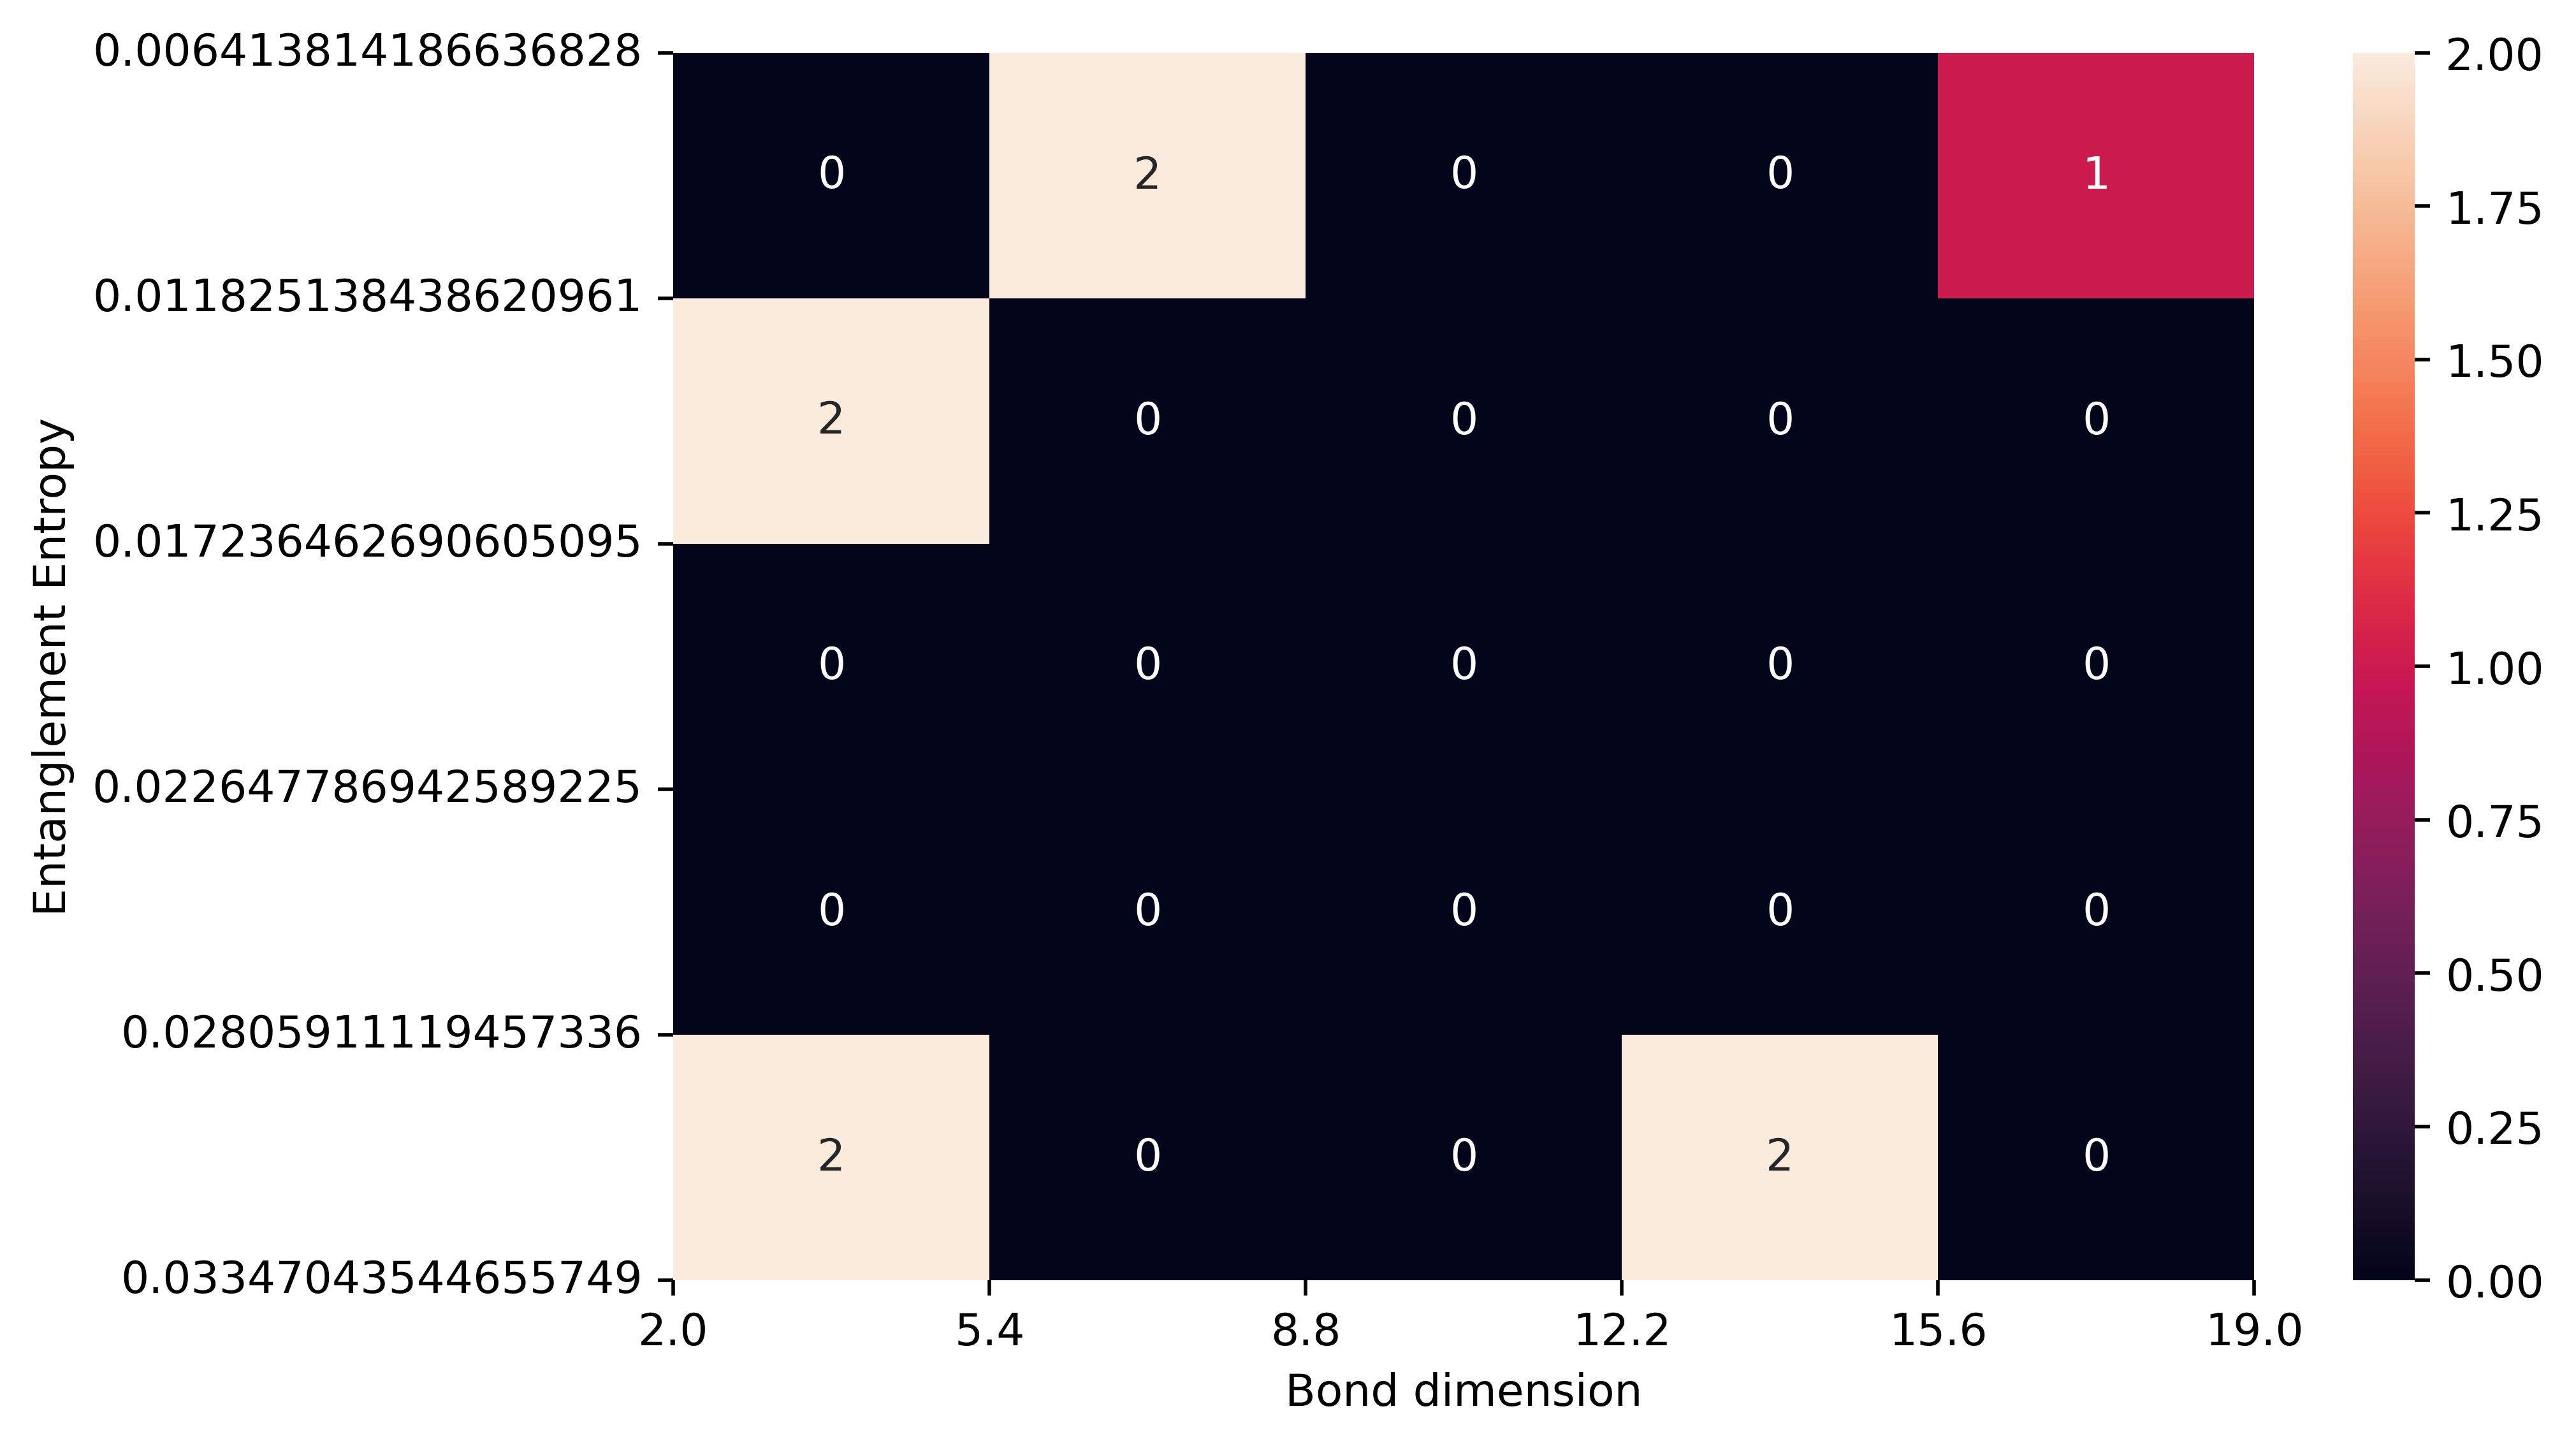

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams['figure.figsize'] = [8,5]

array1 = f
array2 = e

heatmap_data, xedges, yedges = np.histogram2d(array1, array2, bins=5)

ax = sns.heatmap(heatmap_data.T, annot=True, fmt=".0f")

ax.set_xticks(np.arange(len(xedges)))
ax.set_yticks(np.arange(len(yedges)))
ax.set_xticklabels(xedges, rotation=0)
ax.set_yticklabels(yedges, rotation=0)

plt.xlabel("Bond dimension")
plt.ylabel("Entanglement Entropy")
plt.savefig("NEW_Plot",dpi=500)
plt.show()

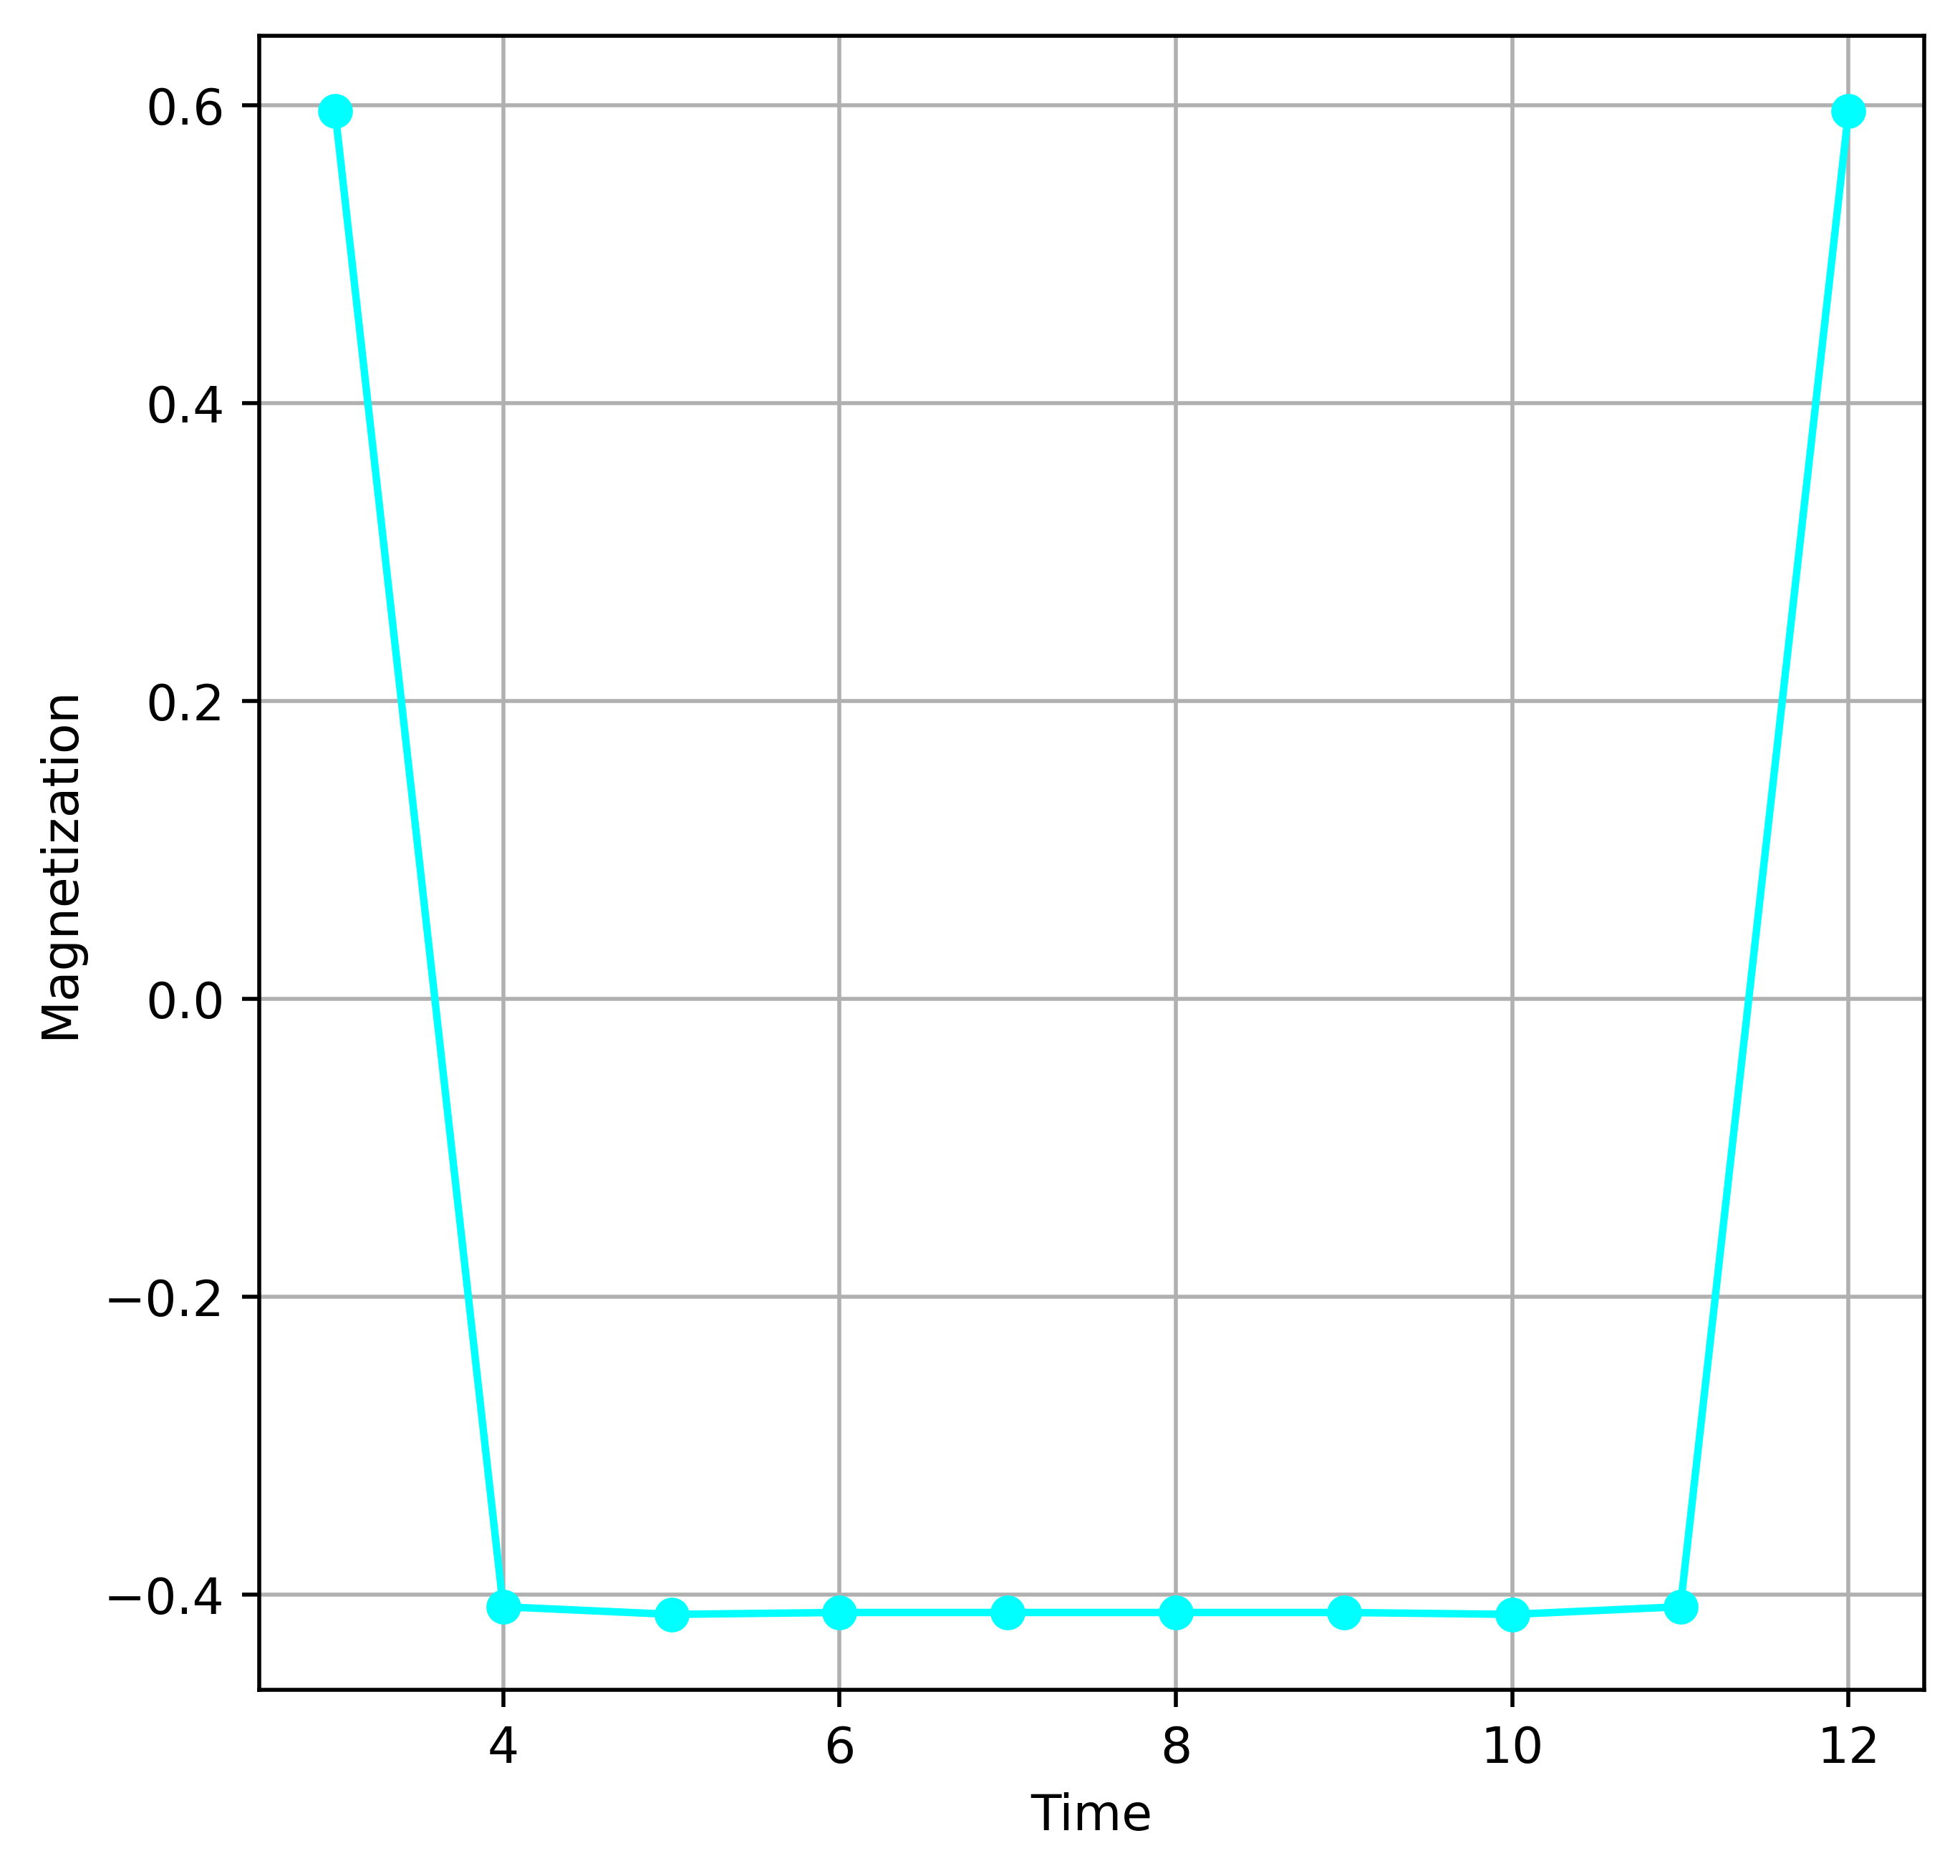

In [78]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [6, 6]
t_new=np.linspace(12,1,12)
plt.rcParams['figure.dpi'] = 500
plt.plot(t_new[:10],d,marker='o',linestyle='-',color='cyan')
plt.xlabel('Time')
plt.ylabel('Magnetization')
plt.grid()
plt.savefig("magnetization for TLFI-Model")
plt.show()

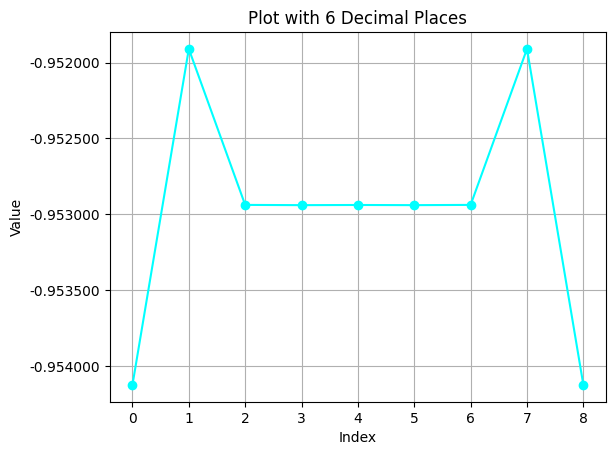

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

c = [ -0.95412613, -0.95190988, -0.95293873, -0.95294033,
     -0.95293922, -0.95294033, -0.95293873, -0.95190988, -0.95412613]

plt.plot(range(len(c)), c, marker='o', linestyle='-', color='cyan')

# Format the y-axis to display 6 decimal places
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.6f'))

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot with 6 Decimal Places')
plt.grid(True)
plt.show()

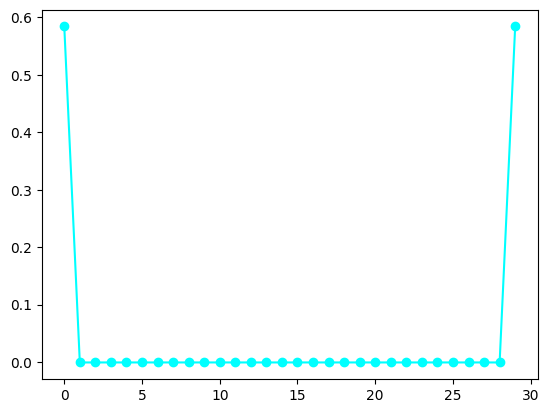

In [ ]:
# d[0]=1
# d[len(d)-1]=0
plt.plot(range(len(d)),d,marker='o',linestyle='-',color='cyan')

#**Driven dynamics and entanglement steering**

In [116]:
def example_TEBD_gs_tf_ising_finite(L, g, chi_max=30):
    mag_x=[]
    print("finite TEBD, imaginary time evolution, transverse and longitudinal field Ising")
    print("L={L:d}, g={g:.2f}".format(L=L, g=g))
    # from . import a_mps
    # from . import b_model
    t_new=[0,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,1,1.2,1.4,1.6]

    # Use a for loop to iterate through values in t_new
    for dt in t_new:
        if dt <= 0.4: # Condition to stop at 0.6
            model =TLFIModel(L=L, J=0, hs=0,hz=g, bc='finite')
            psi = init_Neel_MPS(model.L, model.d, model.bc)

            U_bonds = calc_U_bonds(model.H_bonds, dt)
            run_TEBD(psi, U_bonds, N_steps=500, chi_max=chi_max, eps=1.e-10)
            E = np.sum(psi.bond_expectation_value(model.H_bonds))
            print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
        elif dt>0.4 and dt <=0.8:
            model =TLFIModel(L=L, J=1, hs=g,hz=0, bc='finite')
            psi = init_Neel_MPS(model.L, model.d, model.bc)

            U_bonds = calc_U_bonds(model.H_bonds, dt)
            run_TEBD(psi, U_bonds, N_steps=500, chi_max=chi_max, eps=1.e-10)
            E = np.sum(psi.bond_expectation_value(model.H_bonds))
            print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
        elif dt>0.8 and dt <=1:
          model =TLFIModel(L=L, J=0, hs=0,hz=g, bc='finite')
          psi = init_Neel_MPS(model.L, model.d, model.bc)
          U_bonds = calc_U_bonds(model.H_bonds, dt)
          run_TEBD(psi, U_bonds, N_steps=500, chi_max=chi_max, eps=1.e-10)
          E = np.sum(psi.bond_expectation_value(model.H_bonds))
          print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
        elif dt>1 and dt <=1.6:
          model =TLFIModel(L=L, J=1, hs=g,hz=0, bc='finite')
          psi = init_Neel_MPS(model.L, model.d, model.bc)

          U_bonds = calc_U_bonds(model.H_bonds, dt)
          run_TEBD(psi, U_bonds, N_steps=500, chi_max=chi_max, eps=1.e-10)
          E = np.sum(psi.bond_expectation_value(model.H_bonds))
          print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))

        else:
            break # Exit loop when dt exceeds 1.0

    print("final bond dimensions: ", psi.get_chi())
    mag_x = psi.site_expectation_value(model.sigmax)
    mag_z_n = psi.site_expectation_value(model.sigmaz)
    mag_x_scalar = (2/L)*np.sum(mag_x)
    mag_z = np.sum(mag_z_n)
    print("Density imbalance for magnetization in X = {mag_x_scalar:.5f}".format(mag_x_scalar=mag_x_scalar))
    print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))
    print("entanglement entropy = ", psi.entanglement_entropy())
    # print("correlation length = ", psi.correlation_length())
    # Return all four intended values
    return mag_x, mag_z_n, psi.entanglement_entropy(), psi.get_chi()

In [125]:
c, c1, c2, c3, c4 ,c5 = [[] for _ in range(6)]
d, d1, d2, d3, d4, d5 = [[] for _ in range(6)]
e, e1, e2, e3, e4, e5 = [[] for _ in range(6)]
f, f1, f2, f3, f4, f5 = [[] for _ in range(6)]
c,  d, e, f =example_TEBD_gs_tf_ising_finite(L=15, g=0.9)
c1,d1,e1,f1 =example_TEBD_gs_tf_ising_finite(L=17, g=0.9)
c2,d2,e2,f2 =example_TEBD_gs_tf_ising_finite(L=19, g=0.9)
c3,d3,e3,f3 =example_TEBD_gs_tf_ising_finite(L=21, g=0.9)
c4,d4,e4,f4 =example_TEBD_gs_tf_ising_finite(L=23, g=0.9)
c5,d5,e5,f5 =example_TEBD_gs_tf_ising_finite(L=25, g=0.9)

finite TEBD, imaginary time evolution, transverse and longitudinal field Ising
L=15, g=0.90
dt = 0.00000: E = 0.0000000000000
dt = 0.25000: E = -0.9000000000000
dt = 0.30000: E = -0.9000000000000
dt = 0.40000: E = -0.9000000000000
dt = 0.50000: E = -14.1403281314071
dt = 0.60000: E = -13.9487015871867
dt = 0.70000: E = -13.7506780790023
dt = 0.75000: E = -13.6511432489727
dt = 0.80000: E = -13.5519686496405
dt = 0.90000: E = -0.9000000000000
dt = 1.00000: E = -0.9000000000000
dt = 1.20000: E = -12.7938087776824
dt = 1.40000: E = -12.4331512343611
dt = 1.60000: E = -12.0723629661999
final bond dimensions:  [2, 4, 8, 16, 30, 30, 30, 30, 30, 30, 16, 8, 4, 2]
Density imbalance for magnetization in X = -0.00000
magnetization in Z = -5.92492
entanglement entropy =  [0.40610006 0.6938039  0.75316847 0.76121421 0.76219086 0.76230955
 0.76232169 0.76232341 0.76230784 0.76219257 0.76121252 0.75317011
 0.69380257 0.4061005 ]
finite TEBD, imaginary time evolution, transverse and longitudinal field

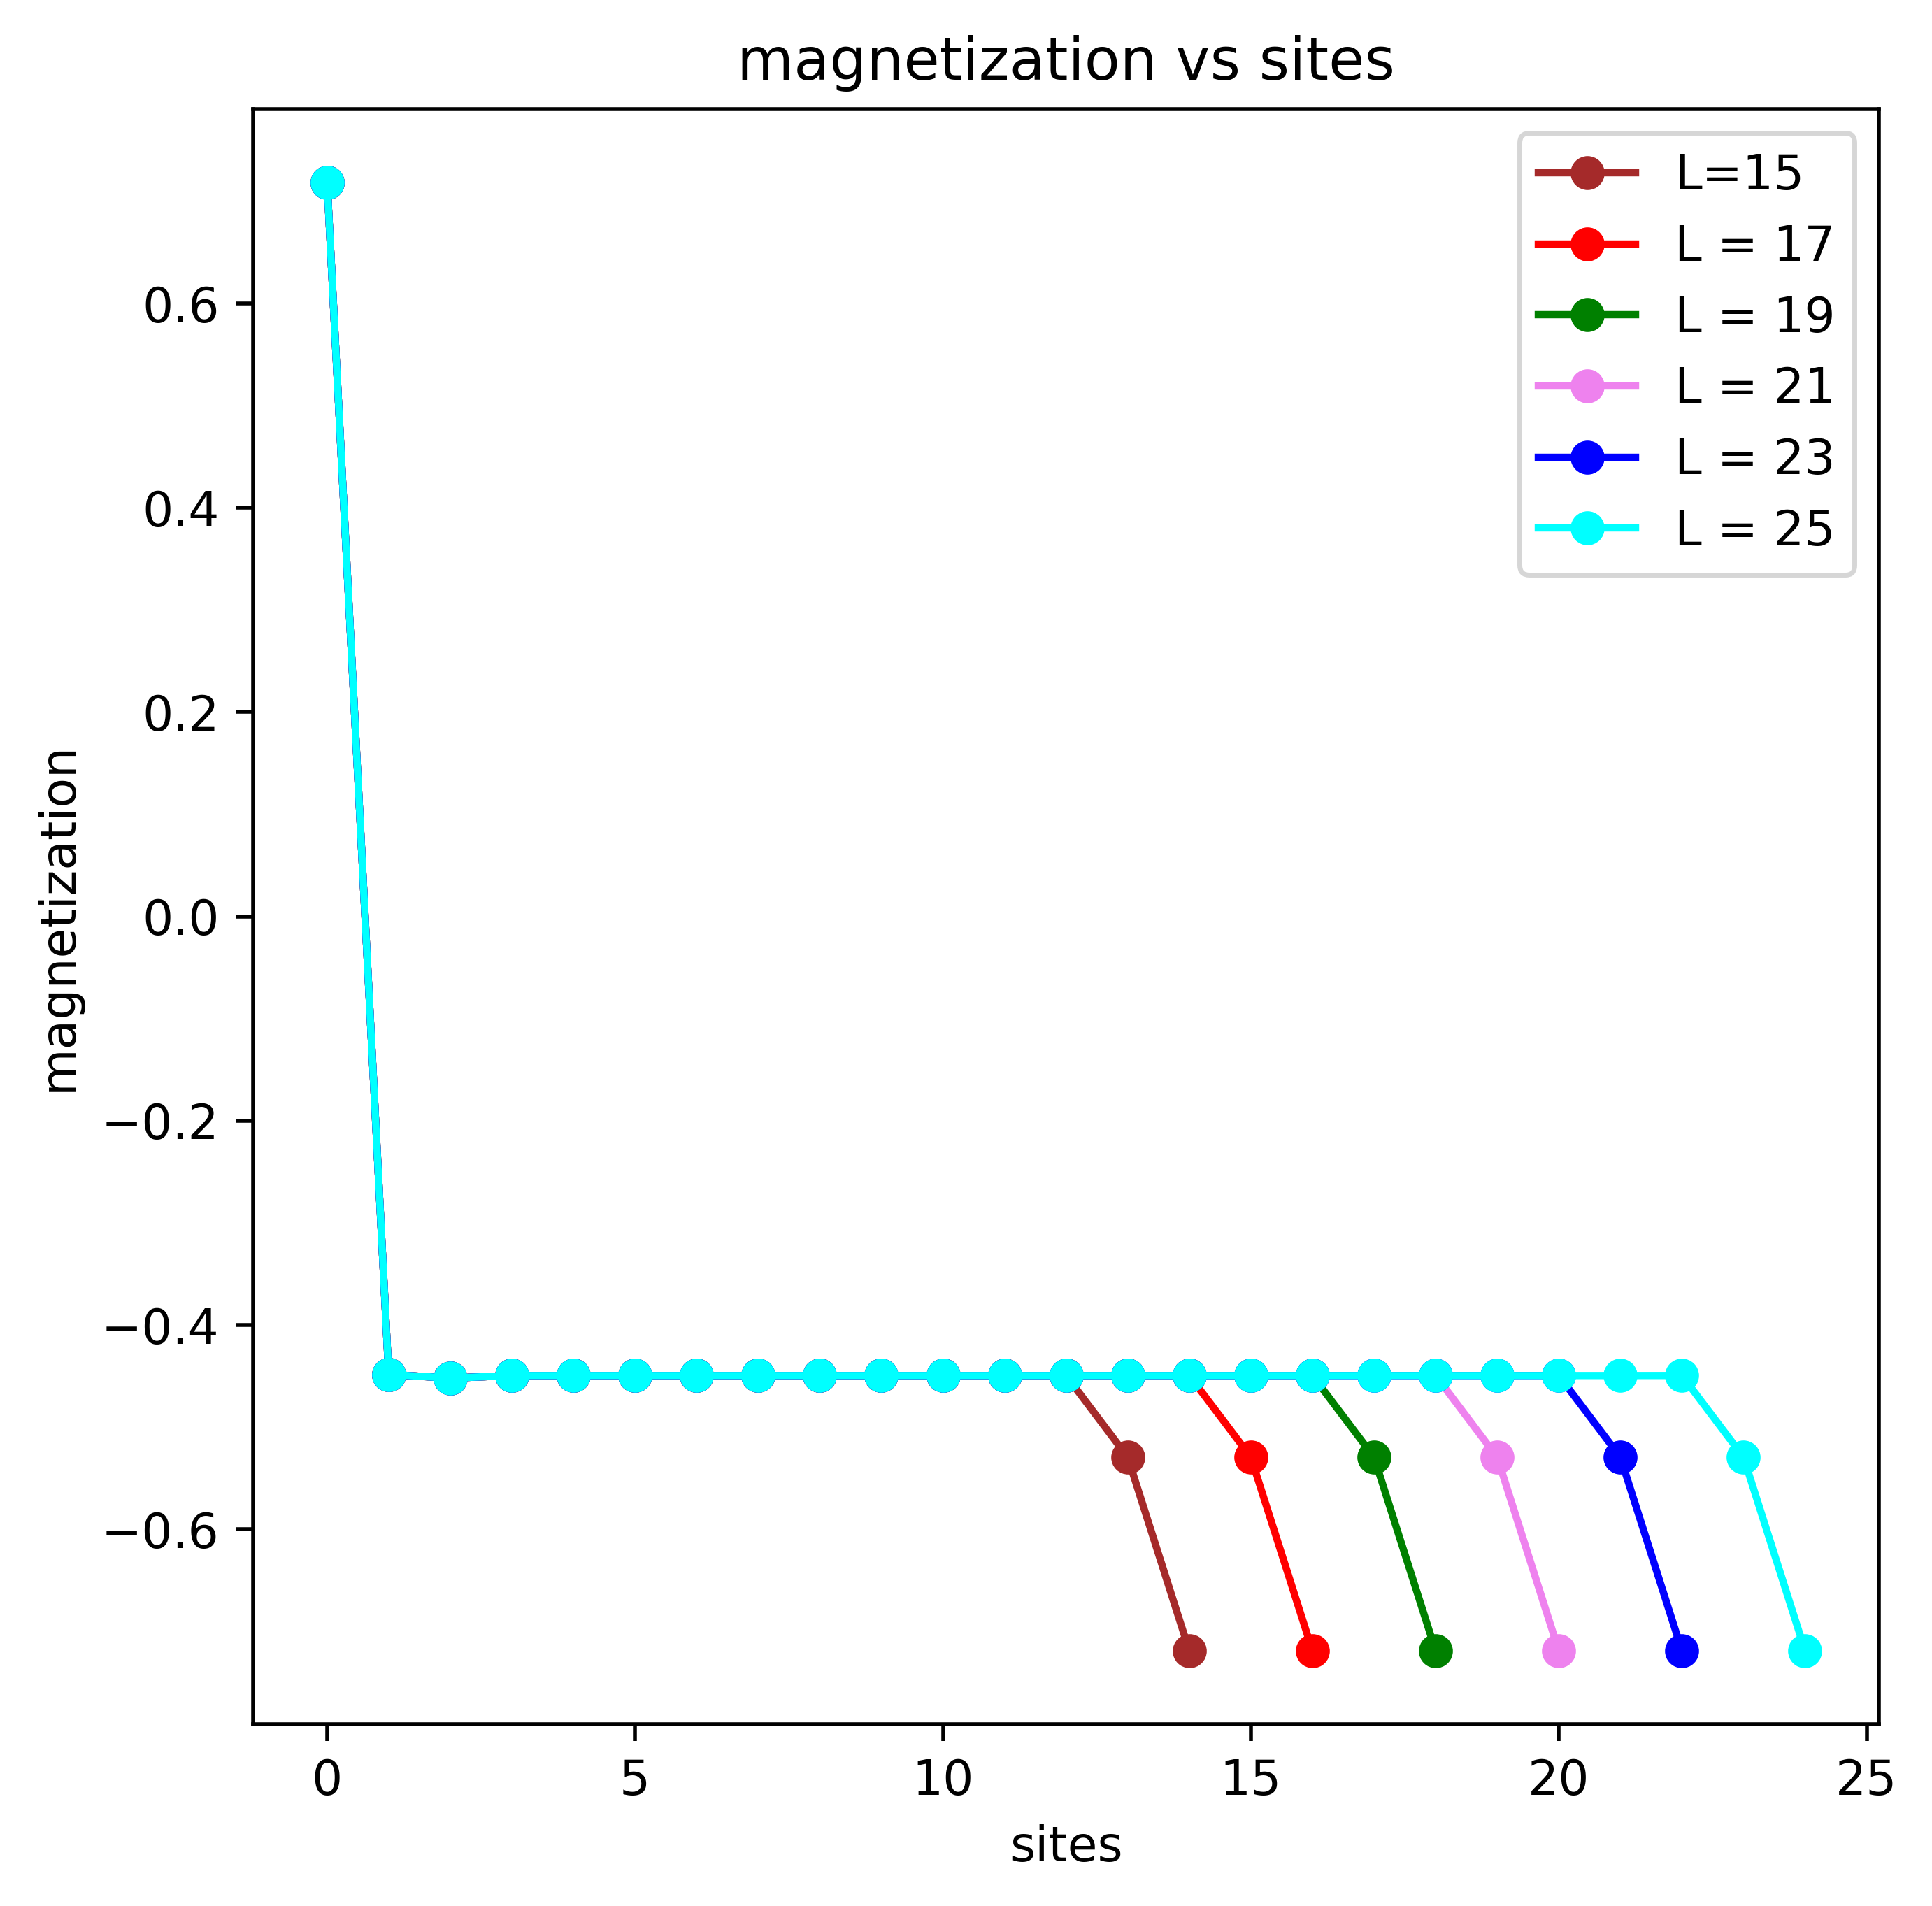

In [126]:
plt.rcParams['figure.figsize'] = (6, 6)
# t_new=np.array([0,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,1])
plt.plot(range(len(d)),d[:],marker='o',color='brown',label = 'L=15')
plt.plot(range(len(d1)),d1[:],marker='o',color='red', label = 'L = 17')
plt.plot(range(len(d2)),d2[:],marker='o',color='green', label = 'L = 19')
plt.plot(range(len(d3)),d3[:],marker='o',color='violet', label = 'L = 21')
plt.plot(range(len(d4)),d4[:],marker='o',color='blue', label = 'L = 23')
plt.plot(range(len(d5)),d5[:],marker='o',color='cyan', label = 'L = 25')
plt.legend()
plt.xlabel("sites")
plt.ylabel("magnetization")
plt.title("magnetization vs sites")
plt.savefig("magnetization for multiple sites")
plt.show()

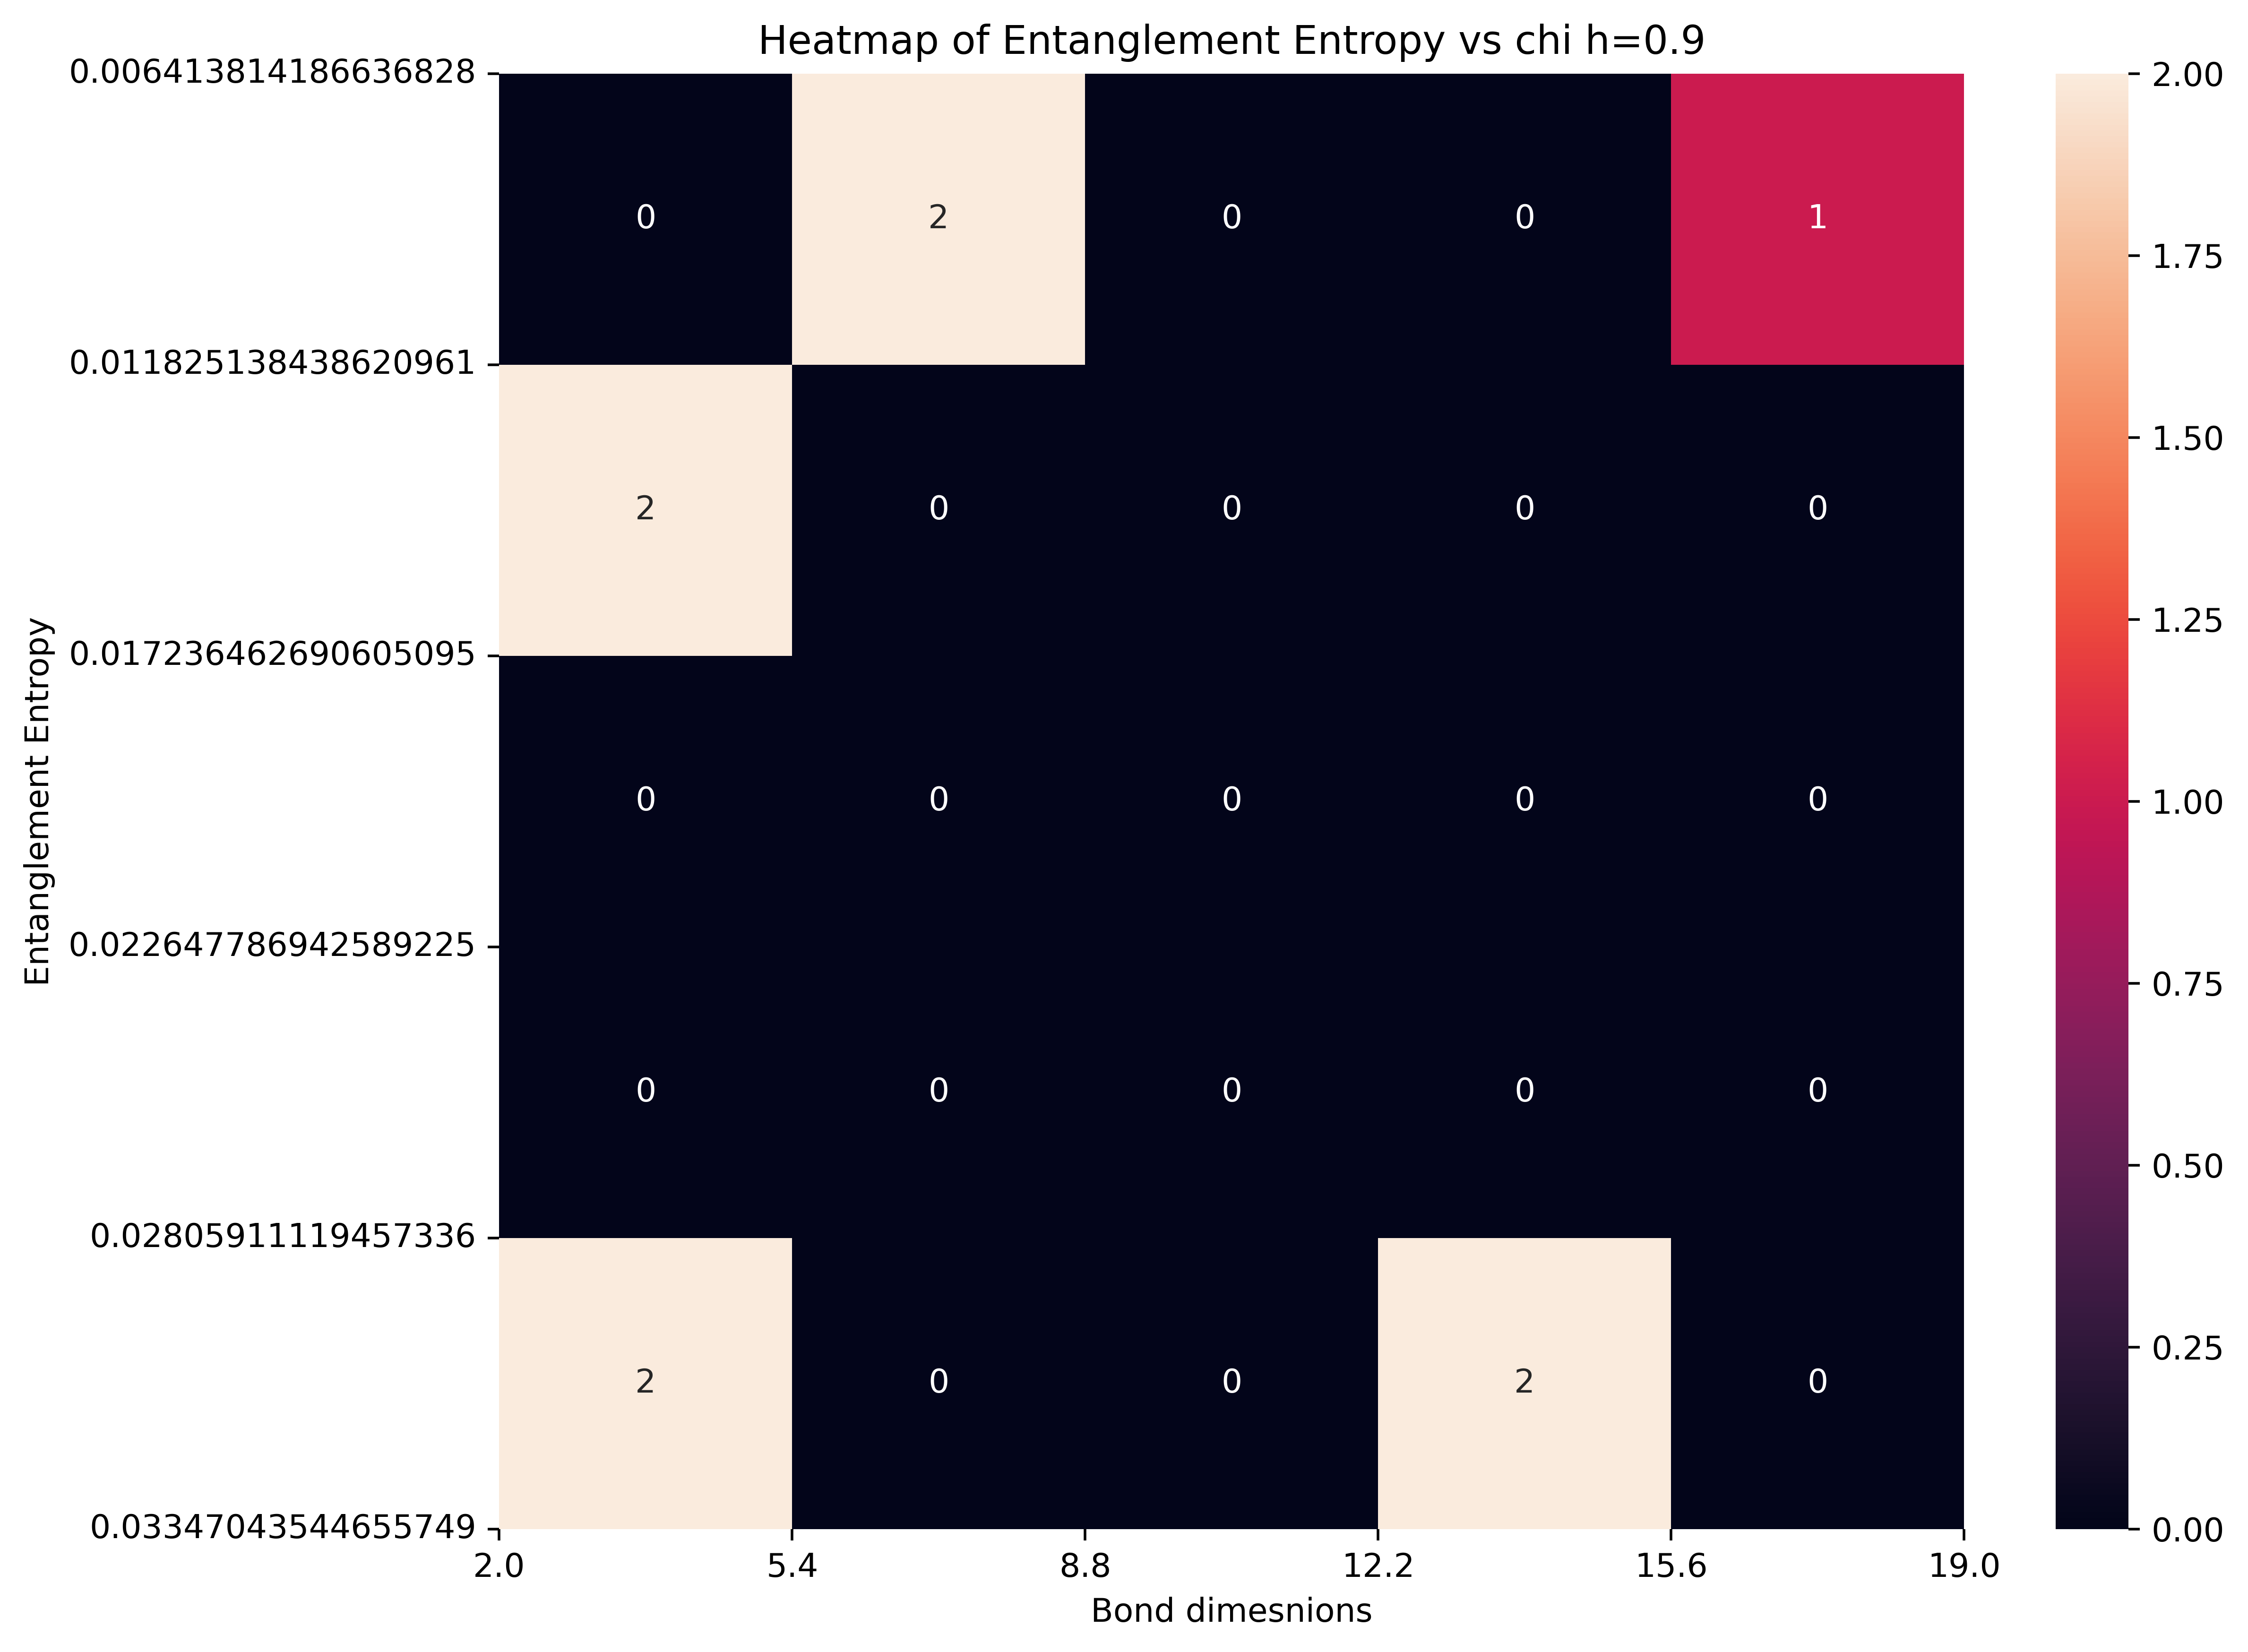

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rcParams['figure.figsize'] = [10, 8]
# Your one-dimensional arrays
array1 = f
array2 = e

# Create a 2D histogram using np.histogram2d()
heatmap_data, xedges, yedges = np.histogram2d(array1, array2, bins=5)

# Plot the heatmap using seaborn
ax = sns.heatmap(heatmap_data.T, annot=True, fmt=".0f")
ax.set_xticks(np.arange(len(xedges)))
ax.set_yticks(np.arange(len(yedges)))
ax.set_xticklabels(xedges, rotation=0)
ax.set_yticklabels(yedges, rotation=0)
plt.xlabel("Bond dimesnions")
plt.ylabel("Entanglement Entropy")
plt.title("Heatmap of Entanglement Entropy vs chi h=0.9")
plt.savefig("Heatmap_of_Entanglement_Entropy_vs_chi")
plt.show()

#***Alternate sequence in driving**

In [ ]:
def example_TEBD_gs_tf_ising_finite(L, g, chi_max=30):
    mag_x=[]
    print("finite TEBD, imaginary time evolution, transverse and longitudinal field Ising")
    print("L={L:d}, g={g:.2f}".format(L=L, g=g))
    # from . import a_mps
    # from . import b_model
    t_new=[0,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,1,1.2,1.4,1.6]

    # Use a for loop to iterate through values in t_new
    for dt in t_new:
        if dt <= 0.4: # Condition to stop at 0.6
            model =TLFIModel(L=L, J=0, hs=0,hz=g, bc='finite')
            psi = init_Neel_MPS(model.L, model.d, model.bc)

            U_bonds = calc_U_bonds(model.H_bonds, dt)
            run_TEBD(psi, U_bonds, N_steps=500, chi_max=chi_max, eps=1.e-10)
            E = np.sum(psi.bond_expectation_value(model.H_bonds))
            print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
        elif dt>0.4 and dt <=0.8:
            model =TLFIModel(L=L, J=1, hs=g,hz=0, bc='finite')
            psi = init_Neel_MPS(model.L, model.d, model.bc)

            U_bonds = calc_U_bonds(model.H_bonds, dt)
            run_TEBD(psi, U_bonds, N_steps=500, chi_max=chi_max, eps=1.e-10)
            E = np.sum(psi.bond_expectation_value(model.H_bonds))
            print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
        elif dt>0.8 and dt <=1:
          model =TLFIModel(L=L, J=0, hs=0,hz=g, bc='finite')
          psi = init_Neel_MPS(model.L, model.d, model.bc)
          U_bonds = calc_U_bonds(model.H_bonds, dt)
          run_TEBD(psi, U_bonds, N_steps=500, chi_max=chi_max, eps=1.e-10)
          E = np.sum(psi.bond_expectation_value(model.H_bonds))
          print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
        elif dt>1 and dt <=1.6:
          model =TLFIModel(L=L, J=1, hs=g,hz=0, bc='finite')
          psi = init_Neel_MPS(model.L, model.d, model.bc)

          U_bonds = calc_U_bonds(model.H_bonds, dt)
          run_TEBD(psi, U_bonds, N_steps=500, chi_max=chi_max, eps=1.e-10)
          E = np.sum(psi.bond_expectation_value(model.H_bonds))
          print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))

        else:
            break # Exit loop when dt exceeds 1.0

    print("final bond dimensions: ", psi.get_chi())
    mag_x = psi.site_expectation_value(model.sigmax)
    mag_z_n = psi.site_expectation_value(model.sigmaz)
    mag_x_scalar = (2/L)*np.sum(mag_x)
    mag_z = np.sum(mag_z_n)
    print("Density imbalance for magnetization in X = {mag_x_scalar:.5f}".format(mag_x_scalar=mag_x_scalar))
    print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))
    print("entanglement entropy = ", psi.entanglement_entropy())
    # print("correlation length = ", psi.correlation_length())
    # Return all four intended values
    return mag_x, mag_z_n, psi.entanglement_entropy(), psi.get_chi()

In [ ]:
c, c1, c2, c3 = [[] for _ in range(4)]
d, d1, d2, d3 = [[] for _ in range(4)]
e, e1, e2, e3 = [[] for _ in range(4)]
f, f1, f2, f3 = [[] for _ in range(4)]
c,  d, e, f =example_TEBD_gs_tf_ising_finite(L=15, g=0.9)
c1,d1,e1,f1 =example_TEBD_gs_tf_ising_finite(L=15, g=0.95)
c2,d2,e2,f2 =example_TEBD_gs_tf_ising_finite(L=15, g=0.89)
c3,d3,e3,f3 =example_TEBD_gs_tf_ising_finite(L=15, g=0.85)

finite TEBD, imaginary time evolution, transverse and longitudinal field Ising
L=15, g=0.90
dt = 0.00000: E = 0.0000000000000
dt = 0.25000: E = -0.9000000000000
dt = 0.30000: E = -0.9000000000000
dt = 0.40000: E = -0.9000000000000
dt = 0.50000: E = -14.1403281314071
dt = 0.60000: E = -13.9487015871867
dt = 0.70000: E = -13.7506780790023
dt = 0.75000: E = -13.6511432489727
dt = 0.80000: E = -13.5519686496405
dt = 0.90000: E = -0.9000000000000
dt = 1.00000: E = -0.9000000000000
dt = 1.20000: E = -12.7938087776824
dt = 1.40000: E = -12.4331512343611
dt = 1.60000: E = -12.0723629661999
final bond dimensions:  [2, 4, 8, 16, 30, 30, 30, 30, 30, 30, 16, 8, 4, 2]
Density imbalance for magnetization in X = -0.00000
magnetization in Z = -5.92492
entanglement entropy =  [0.40610006 0.6938039  0.75316847 0.76121421 0.76219086 0.76230955
 0.76232169 0.76232341 0.76230784 0.76219257 0.76121252 0.75317011
 0.69380257 0.4061005 ]
finite TEBD, imaginary time evolution, transverse and longitudinal field

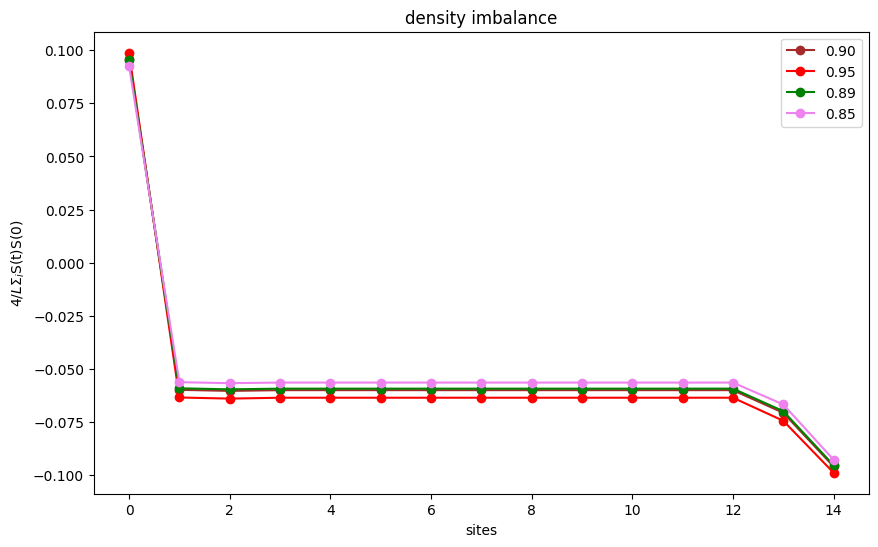

In [ ]:
import matplotlib.pyplot as plt
L=15
plt.rcParams['figure.figsize'] = [10, 6]
# t_new=np.array([0,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,1])
plt.plot(range(len(d)),(2/L)*d[:],marker='o',color='brown',label = '0.90')
plt.plot(range(len(d)),(2/L)*d1[:],marker='o',color='red', label = '0.95')
plt.plot(range(len(d)),(2/L)*d2[:],marker='o',color='green', label = '0.89')
plt.plot(range(len(d)),(2/L)*d3[:],marker='o',color='violet', label = '0.85')
plt.legend()
plt.xlabel("sites")
plt.ylabel("$4/L$$\Sigma_i$S(t)S(0)")
plt.title("density imbalance")
plt.show()

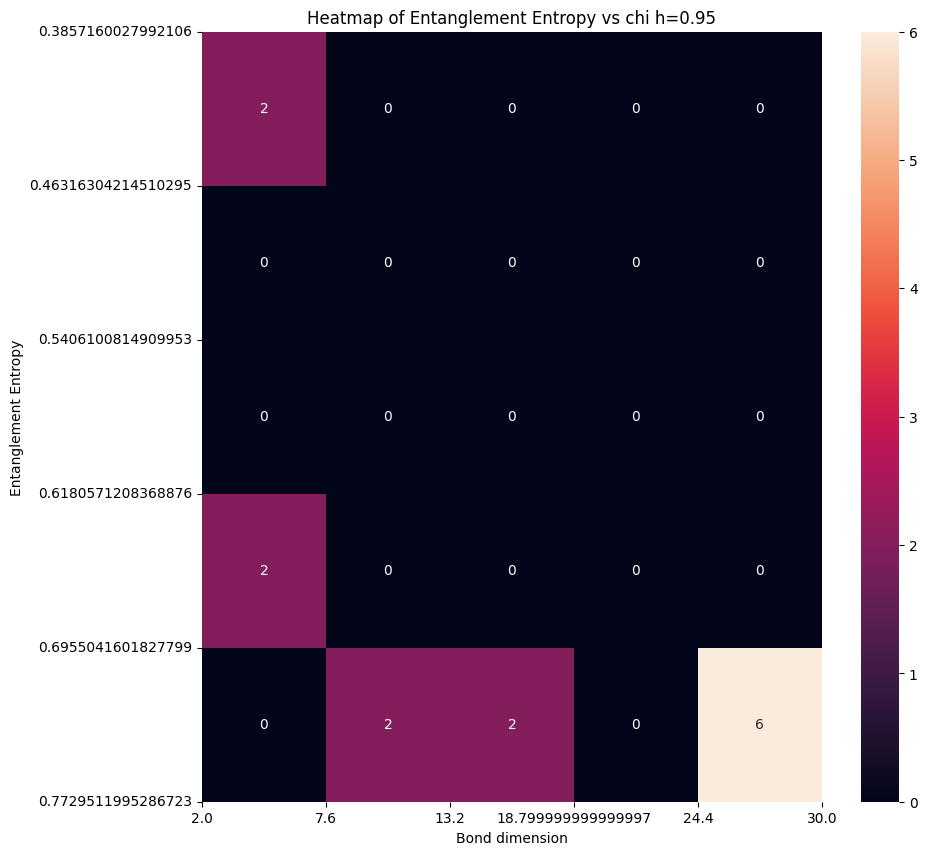

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rcParams['figure.figsize'] = [10, 10]
# Your one-dimensional arrays
array1 = f1
array2 = e1

# Create a 2D histogram using np.histogram2d()
heatmap_data, xedges, yedges = np.histogram2d(array1, array2, bins=5)

# Plot the heatmap using seaborn
ax = sns.heatmap(heatmap_data.T, annot=True, fmt=".0f")
ax.set_xticks(np.arange(len(xedges)))
ax.set_yticks(np.arange(len(yedges)))
ax.set_xticklabels(xedges, rotation=0)
ax.set_yticklabels(yedges, rotation=0)
ax.set_xlabel("Bond dimension")
ax.set_ylabel("Entanglement Entropy")
ax.set_title("Heatmap of Entanglement Entropy vs chi h=0.95")
plt.show()

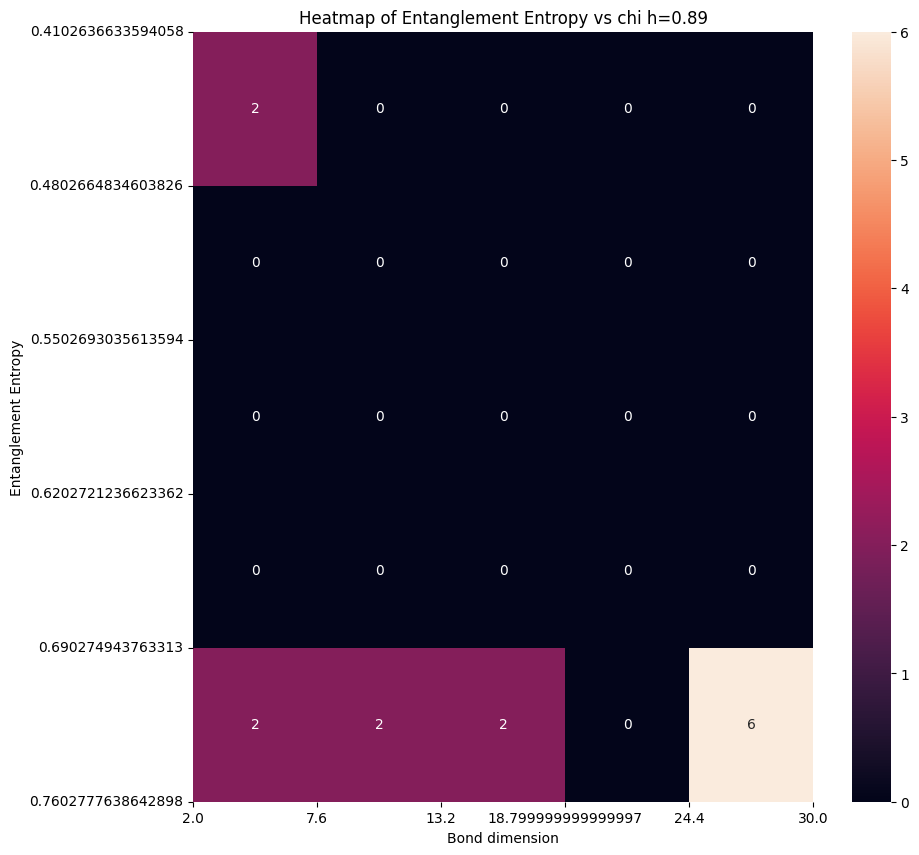

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rcParams['figure.figsize'] = [10, 10]
# Your one-dimensional arrays
array1 = f2
array2 = e2

# Create a 2D histogram using np.histogram2d()
heatmap_data, xedges, yedges = np.histogram2d(array1, array2, bins=5)

# Plot the heatmap using seaborn
ax = sns.heatmap(heatmap_data.T, annot=True, fmt=".0f")
ax.set_xticks(np.arange(len(xedges)))
ax.set_yticks(np.arange(len(yedges)))
ax.set_xticklabels(xedges, rotation=0)
ax.set_yticklabels(yedges, rotation=0)
ax.set_xlabel("Bond dimension")
ax.set_ylabel("Entanglement Entropy")
ax.set_title("Heatmap of Entanglement Entropy vs chi h=0.89")
plt.show()

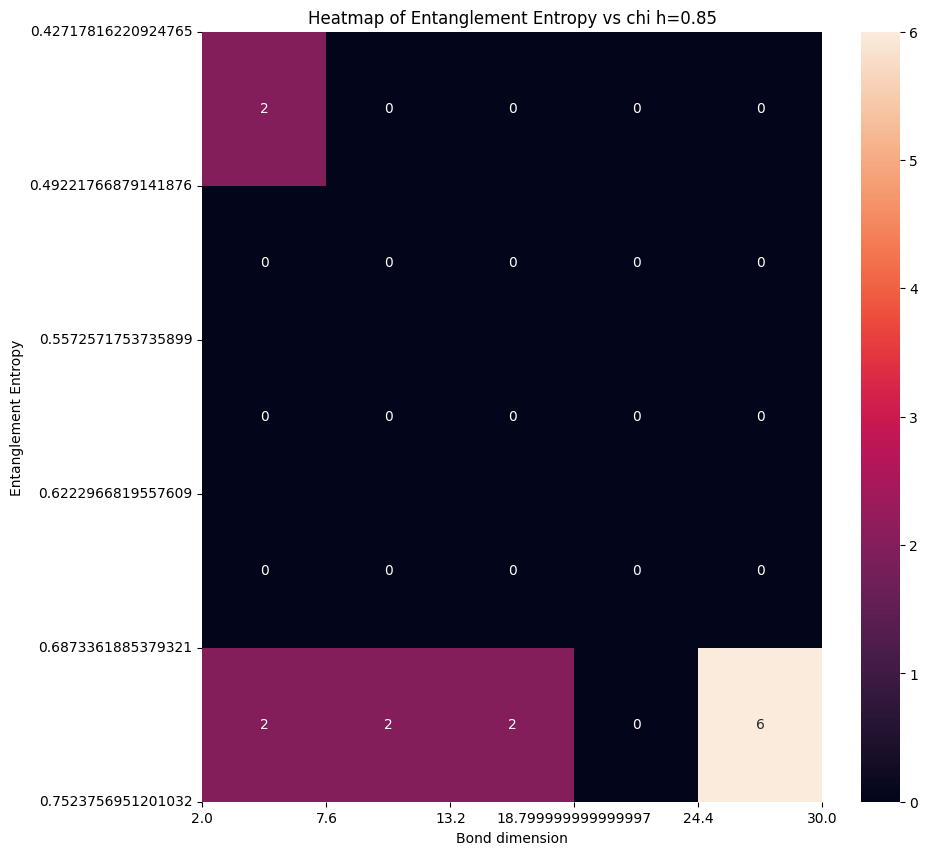

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rcParams['figure.figsize'] = [10, 10]
# Your one-dimensional arrays
array1 = f3
array2 = e3

# Create a 2D histogram using np.histogram2d()
heatmap_data, xedges, yedges = np.histogram2d(array1, array2, bins=5)

# Plot the heatmap using seaborn
ax = sns.heatmap(heatmap_data.T, annot=True, fmt=".0f")
ax.set_xticks(np.arange(len(xedges)))
ax.set_yticks(np.arange(len(yedges)))
ax.set_xticklabels(xedges, rotation=0)
ax.set_yticklabels(yedges, rotation=0)
ax.set_xlabel("Bond dimension")
ax.set_ylabel("Entanglement Entropy")
ax.set_title("Heatmap of Entanglement Entropy vs chi h=0.85")
plt.show()

#**Angular Variation (Θ=π/3) || Entanglement Entropy HeatMap**

In [ ]:
import numpy as np
from scipy.linalg import expm
# from .a_mps import split_truncate_theta

theta = np.pi/3
def calc_U_bonds(H_bonds, dt,N):
    ang_var = N*theta
    d = H_bonds[0].shape[0]
    U_bonds = []
    for H in H_bonds:
        H = np.reshape(H + ang_var, [d * d, d * d])
        U = expm(-dt * H) #*expm(-ang_var)
        U_bonds.append(np.reshape(U, [d, d, d, d]))
    return U_bonds


def run_TEBD(psi, U_bonds, N_steps, chi_max, eps):

    Nbonds = psi.L - 1 if psi.bc == 'finite' else psi.L
    assert len(U_bonds) == Nbonds
    for n in range(N_steps):
        for k in [0, 1]:  # even, odd
            for i_bond in range(k, Nbonds, 2):
                update_bond(psi, i_bond, U_bonds[i_bond], chi_max, eps)
    # done


def update_bond(psi, i, U_bond, chi_max, eps):

    j = (i + 1) % psi.L
    # construct theta matrix
    theta = psi.get_theta2(i)  # vL i j vR
    # apply U
    Utheta = np.tensordot(U_bond, theta, axes=([2, 3], [1, 2]))  # i j [i*] [j*], vL [i] [j] vR
    Utheta = np.transpose(Utheta, [2, 0, 1, 3])  # vL i j vR
    # split and truncate
    Ai, Sj, Bj = split_truncate_theta(Utheta, chi_max, eps)
    # put back into MPS
    Gi = np.tensordot(np.diag(psi.Ss[i]**(-1)), Ai, axes=(1, 0))  # vL [vL*], [vL] i vC
    psi.Bs[i] = np.tensordot(Gi, np.diag(Sj), axes=(2, 0))  # vL i [vC], [vC] vC
    psi.Ss[j] = Sj  # vC
    psi.Bs[j] = Bj  # vC j vR


def example_TEBD_gs_tf_ising_finite(L, g, chi_max=30):
    mag_x=[]
    print("finite TEBD, imaginary time evolution, transverse field Ising")
    print("L={L:d}, g={g:.2f}".format(L=L, g=g))
    # from . import a_mps
    # from . import b_model
    model =TLFIModel(L=L, J=1., hs=g,hz=0.5, bc='finite')
    psi = init_Neel_MPS(model.L, model.d, model.bc)
    t_new=np.linspace(12,1,12)
    N = 0
    for dt in t_new:
      desired_B = np.array([[[1.], [0.]]])
      for i, B in enumerate(psi.Bs):
          if np.array_equal(B,desired_B):
            N +=1
      U_bonds = calc_U_bonds(model.H_bonds, dt,N)
      run_TEBD(psi, U_bonds, N_steps=500, chi_max=chi_max, eps=1.e-10)
      E = np.sum(psi.bond_expectation_value(model.H_bonds))
      print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
    print("final bond dimensions: ", psi.get_chi())
    mag_x = psi.site_expectation_value(model.sigmax)
    mag_z_n = psi.site_expectation_value(model.sigmaz)
    mag_x_scalar = (2/L)*np.sum(mag_x)
    mag_z = np.sum(mag_z_n)
    print("Density imbalance for magnetization in X = {mag_x_scalar:.5f}".format(mag_x_scalar=mag_x_scalar))
    print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))
    print("entanglement entropy = ", psi.entanglement_entropy())
    # print("the value of the number operator =",N)
    # print("correlation length = ", psi.correlation_length())
    # Return all four intended values
    return mag_x, mag_z_n, psi.entanglement_entropy(), psi.get_chi()

In [ ]:
c,  d, e, f =example_TEBD_gs_tf_ising_finite(L=15, g=0.9)

finite TEBD, imaginary time evolution, transverse field Ising
L=15, g=0.90
dt = 12.00000: E = -13.3211292366812
dt = 11.00000: E = -13.3211292366883
dt = 10.00000: E = -13.3211292367930
dt = 9.00000: E = -13.3211292378769
dt = 8.00000: E = -13.3211292480208
dt = 7.00000: E = -13.3211293423729
dt = 6.00000: E = -13.3211302763669
dt = 5.00000: E = -13.3211406436330
dt = 4.00000: E = -13.3212718687048
dt = 3.00000: E = -13.3231183696308
dt = 2.00000: E = -13.3502711433128
dt = 1.00000: E = -13.6857569329327
final bond dimensions:  [2, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 2]
Density imbalance for magnetization in X = -1.85992
magnetization in Z = -3.45810
entanglement entropy =  [0.0221444  0.0026972  0.00720814 0.00260458 0.00720601 0.00260458
 0.00720601 0.00260458 0.00720601 0.00260458 0.00720603 0.0026053
 0.00739832 0.0084967 ]


#**Undriven case for Θ=π/3**

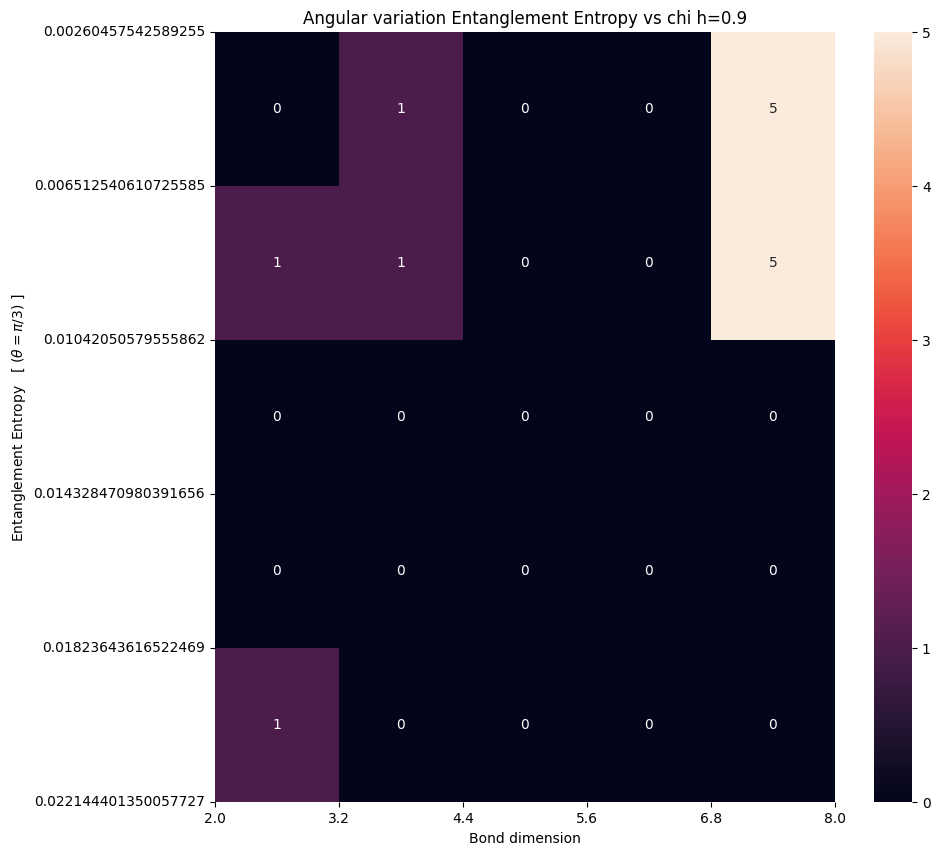

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rcParams['figure.figsize'] = [10, 10]
# Your one-dimensional arrays
array1 = f
array2 = e

# Create a 2D histogram using np.histogram2d()
heatmap_data, xedges, yedges = np.histogram2d(array1, array2, bins=5)

# Plot the heatmap using seaborn
ax = sns.heatmap(heatmap_data.T, annot=True, fmt=".0f")
ax.set_xticks(np.arange(len(xedges)))
ax.set_yticks(np.arange(len(yedges)))
ax.set_xticklabels(xedges, rotation=0)
ax.set_yticklabels(yedges, rotation=0)
ax.set_xlabel("Bond dimension")
ax.set_ylabel("Entanglement Entropy   [ ($\u03B8 = \u03C0 /3$) ]")
ax.set_title("Angular variation Entanglement Entropy vs chi h=0.9")
plt.show()

#**Alternate Driven Case for theta=π/3**

In [ ]:
import numpy as np
from scipy.linalg import expm
# from .a_mps import split_truncate_theta

theta = np.pi/3
def calc_U_bonds(H_bonds, dt,N):
    ang_var = N*theta
    d = H_bonds[0].shape[0]
    U_bonds = []
    for H in H_bonds:
        H = np.reshape(H + ang_var, [d * d, d * d])
        U = expm(-dt * H) #*expm(-ang_var)
        U_bonds.append(np.reshape(U, [d, d, d, d]))
    return U_bonds


def run_TEBD(psi, U_bonds, N_steps, chi_max, eps):

    Nbonds = psi.L - 1 if psi.bc == 'finite' else psi.L
    assert len(U_bonds) == Nbonds
    for n in range(N_steps):
        for k in [0, 1]:  # even, odd
            for i_bond in range(k, Nbonds, 2):
                update_bond(psi, i_bond, U_bonds[i_bond], chi_max, eps)
    # done


def update_bond(psi, i, U_bond, chi_max, eps):

    j = (i + 1) % psi.L
    # construct theta matrix
    theta = psi.get_theta2(i)  # vL i j vR
    # apply U
    Utheta = np.tensordot(U_bond, theta, axes=([2, 3], [1, 2]))  # i j [i*] [j*], vL [i] [j] vR
    Utheta = np.transpose(Utheta, [2, 0, 1, 3])  # vL i j vR
    # split and truncate
    Ai, Sj, Bj = split_truncate_theta(Utheta, chi_max, eps)
    # put back into MPS
    Gi = np.tensordot(np.diag(psi.Ss[i]**(-1)), Ai, axes=(1, 0))  # vL [vL*], [vL] i vC
    psi.Bs[i] = np.tensordot(Gi, np.diag(Sj), axes=(2, 0))  # vL i [vC], [vC] vC
    psi.Ss[j] = Sj  # vC
    psi.Bs[j] = Bj  # vC j vR

def example_TEBD_gs_tf_ising_finite(L, g, chi_max=30):
    mag_x=[]
    print("finite TEBD, imaginary time evolution, transverse and longitudinal field Ising")
    print("L={L:d}, g={g:.2f}".format(L=L, g=g))
    # from . import a_mps
    # from . import b_model
    t_new=[0,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,1,1.2,1.4,1.6]

    # Use a for loop to iterate through values in t_new
    for dt in t_new:
        if dt <= 0.4: # Condition to stop at 0.6
            model =TLFIModel(L=L, J=0, hs=0,hz=g, bc='finite')
            psi = init_Neel_MPS(model.L, model.d, model.bc)
            N = 0
            desired_B = np.array([[[1.], [0.]]])
            for i, B in enumerate(psi.Bs):
                if np.array_equal(B,desired_B):
                  N +=1
            U_bonds = calc_U_bonds(model.H_bonds, dt,N)
            run_TEBD(psi, U_bonds, N_steps=500, chi_max=chi_max, eps=1.e-10)
            E = np.sum(psi.bond_expectation_value(model.H_bonds))
            print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
        elif dt>0.4 and dt <=0.8:
            model =TLFIModel(L=L, J=1, hs=g,hz=0, bc='finite')
            psi = init_Neel_MPS(model.L, model.d, model.bc)
            desired_B = np.array([[[1.], [0.]]])
            for i, B in enumerate(psi.Bs):
              if np.array_equal(B,desired_B):
                N +=1
            U_bonds = calc_U_bonds(model.H_bonds, dt,N)
            run_TEBD(psi, U_bonds, N_steps=500, chi_max=chi_max, eps=1.e-10)
            E = np.sum(psi.bond_expectation_value(model.H_bonds))
            print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
        elif dt>0.8 and dt <=1:
          model =TLFIModel(L=L, J=0, hs=0,hz=g, bc='finite')
          psi = init_Neel_MPS(model.L, model.d, model.bc)
          desired_B = np.array([[[1.], [0.]]])
          for i, B in enumerate(psi.Bs):
            if np.array_equal(B,desired_B):
              N +=1
          U_bonds = calc_U_bonds(model.H_bonds, dt,N)
          run_TEBD(psi, U_bonds, N_steps=500, chi_max=chi_max, eps=1.e-10)
          E = np.sum(psi.bond_expectation_value(model.H_bonds))
          print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
        elif dt>1 and dt <=1.6:
          model =TLFIModel(L=L, J=1, hs=g,hz=0, bc='finite')
          psi = init_Neel_MPS(model.L, model.d, model.bc)
          desired_B = np.array([[[1.], [0.]]])
          for i, B in enumerate(psi.Bs):
            if np.array_equal(B,desired_B):
              N +=1
          U_bonds = calc_U_bonds(model.H_bonds, dt,N)
          run_TEBD(psi, U_bonds, N_steps=500, chi_max=chi_max, eps=1.e-10)
          E = np.sum(psi.bond_expectation_value(model.H_bonds))
          print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))

        else:
            break # Exit loop when dt exceeds 1.0

    print("final bond dimensions: ", psi.get_chi())
    mag_x = psi.site_expectation_value(model.sigmax)
    mag_z_n = psi.site_expectation_value(model.sigmaz)
    mag_x_scalar = (2/L)*np.sum(mag_x)
    mag_z = np.sum(mag_z_n)
    print("Density imbalance for magnetization in X = {mag_x_scalar:.5f}".format(mag_x_scalar=mag_x_scalar))
    print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))
    print("entanglement entropy = ", psi.entanglement_entropy())
    # print("correlation length = ", psi.correlation_length())
    # Return all four intended values
    return mag_x, mag_z_n, psi.entanglement_entropy(), psi.get_chi()

In [ ]:
c, c1, c2, c3 = [[] for _ in range(4)]
d, d1, d2, d3 = [[] for _ in range(4)]
e, e1, e2, e3 = [[] for _ in range(4)]
f, f1, f2, f3 = [[] for _ in range(4)]
c,  d, e, f =example_TEBD_gs_tf_ising_finite(L=15, g=0.9)
c1,d1,e1,f1 =example_TEBD_gs_tf_ising_finite(L=15, g=0.95)
c2,d2,e2,f2 =example_TEBD_gs_tf_ising_finite(L=15, g=0.89)
c3,d3,e3,f3 =example_TEBD_gs_tf_ising_finite(L=15, g=0.85)

finite TEBD, imaginary time evolution, transverse and longitudinal field Ising
L=15, g=0.90
dt = 0.00000: E = 0.0000000000000
dt = 0.25000: E = -1.4027238470251
dt = 0.30000: E = -1.5288951801814
dt = 0.40000: E = -1.8052368098253
dt = 0.50000: E = -14.1625938652171
dt = 0.60000: E = -13.9868375460869
dt = 0.70000: E = -13.8121612693315
dt = 0.75000: E = -13.7278065644905
dt = 0.80000: E = -13.6464101037830
dt = 0.90000: E = -3.4483193654175
dt = 1.00000: E = -3.7709786032203
dt = 1.20000: E = -13.1422271322314
dt = 1.40000: E = -12.9888156694702
dt = 1.60000: E = -12.8853467509346
final bond dimensions:  [2, 4, 7, 8, 8, 8, 8, 8, 8, 8, 8, 7, 4, 2]
Density imbalance for magnetization in X = -1.81521
magnetization in Z = -4.67033
entanglement entropy =  [0.02147355 0.00957315 0.00949633 0.00949598 0.00949598 0.00949598
 0.00949598 0.00949598 0.00949598 0.00949598 0.00949598 0.00949633
 0.00957315 0.02147355]
finite TEBD, imaginary time evolution, transverse and longitudinal field Ising
L

#**L = 15 site for h = 0.9,0.95,0.89,0.85**

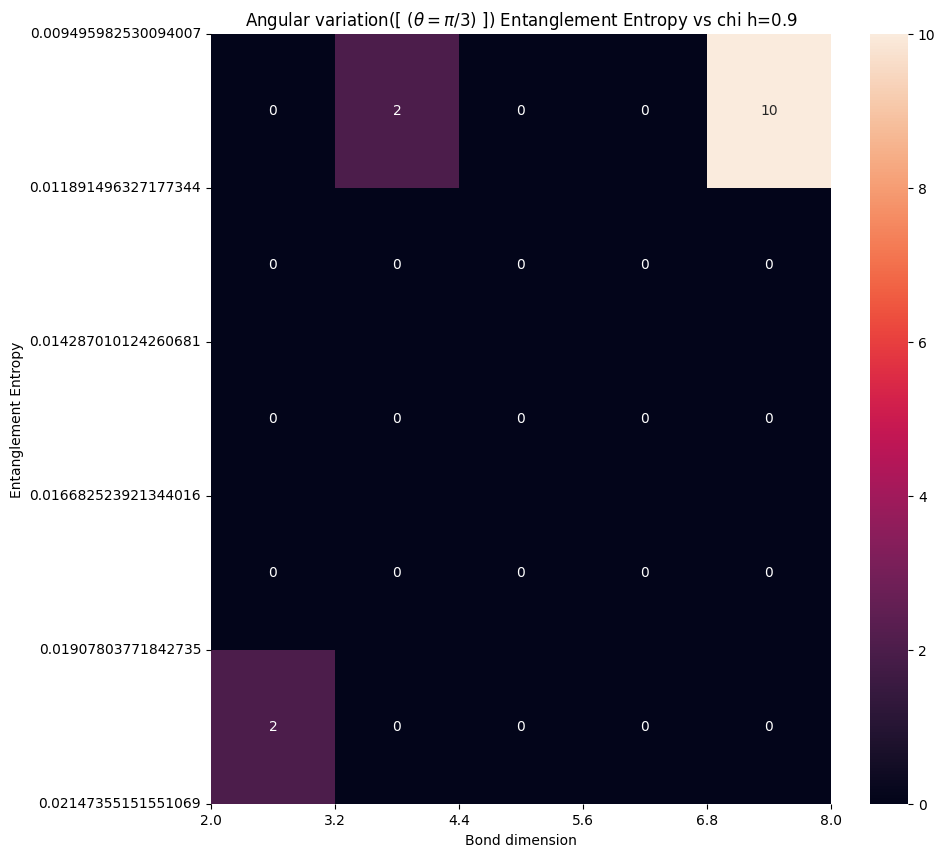

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rcParams['figure.figsize'] = [10, 10]
# Your one-dimensional arrays
array1 = f
array2 = e

# Create a 2D histogram using np.histogram2d()
heatmap_data, xedges, yedges = np.histogram2d(array1, array2, bins=5)

# Plot the heatmap using seaborn
ax = sns.heatmap(heatmap_data.T, annot=True, fmt=".0f")
ax.set_xticks(np.arange(len(xedges)))
ax.set_yticks(np.arange(len(yedges)))
ax.set_xticklabels(xedges, rotation=0)
ax.set_yticklabels(yedges, rotation=0)
ax.set_xlabel("Bond dimension")
ax.set_ylabel("Entanglement Entropy")
ax.set_title("Angular variation([ ($\u03B8 = \u03C0 /3$) ]) Entanglement Entropy vs chi h=0.9")
plt.show()

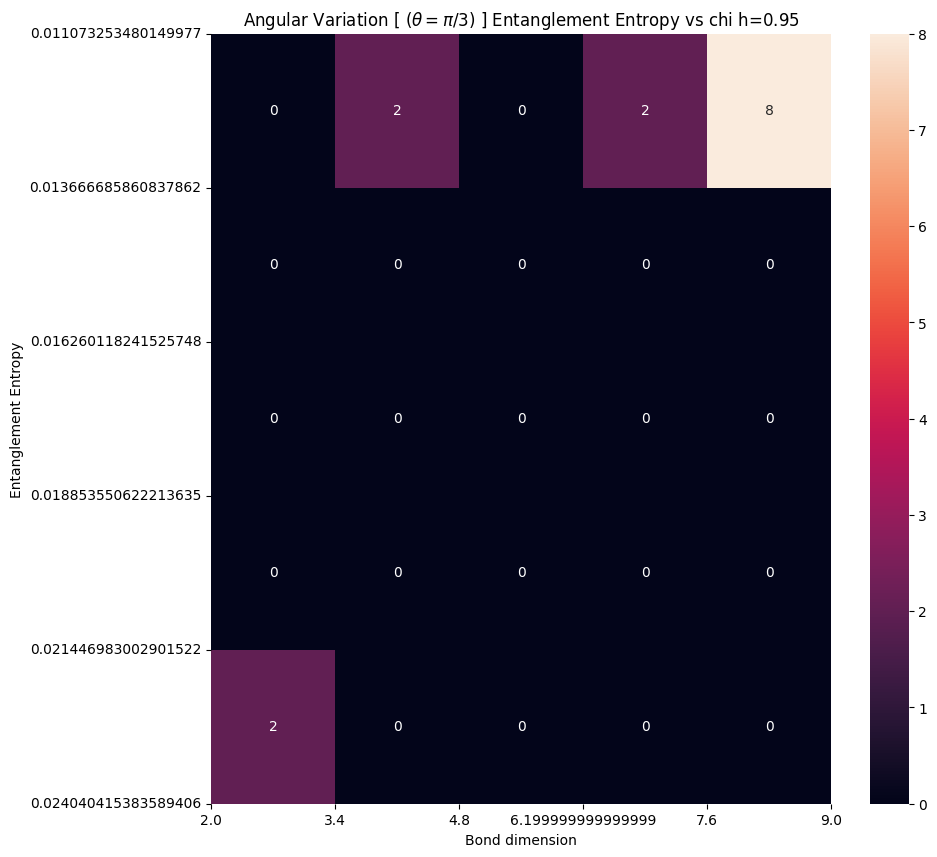

In [ ]:
array1 = f1
array2 = e1

# Create a 2D histogram using np.histogram2d()
heatmap_data, xedges, yedges = np.histogram2d(array1, array2, bins=5)

# Plot the heatmap using seaborn
ax = sns.heatmap(heatmap_data.T, annot=True, fmt=".0f")
ax.set_xticks(np.arange(len(xedges)))
ax.set_yticks(np.arange(len(yedges)))
ax.set_xticklabels(xedges, rotation=0)
ax.set_yticklabels(yedges, rotation=0)
ax.set_xlabel("Bond dimension")
ax.set_ylabel("Entanglement Entropy")
ax.set_title("Angular Variation [ ($\u03B8 = \u03C0 /3$) ] Entanglement Entropy vs chi h=0.95")
plt.show()

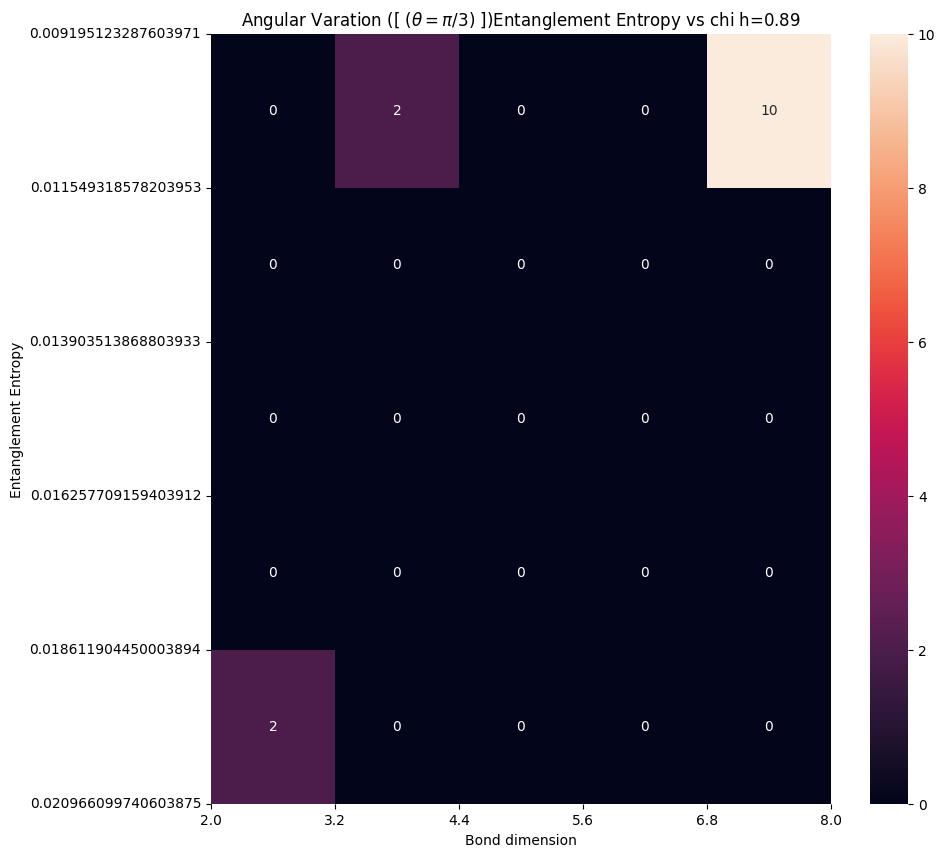

In [ ]:
array1 = f2
array2 = e2

# Create a 2D histogram using np.histogram2d()
heatmap_data, xedges, yedges = np.histogram2d(array1, array2, bins=5)

# Plot the heatmap using seaborn
ax = sns.heatmap(heatmap_data.T, annot=True, fmt=".0f")
ax.set_xticks(np.arange(len(xedges)))
ax.set_yticks(np.arange(len(yedges)))
ax.set_xticklabels(xedges, rotation=0)
ax.set_yticklabels(yedges, rotation=0)
ax.set_xlabel("Bond dimension")
ax.set_ylabel("Entanglement Entropy")
ax.set_title("Angular Varation ([ ($\u03B8 = \u03C0 /3$) ])Entanglement Entropy vs chi h=0.89")
plt.show()

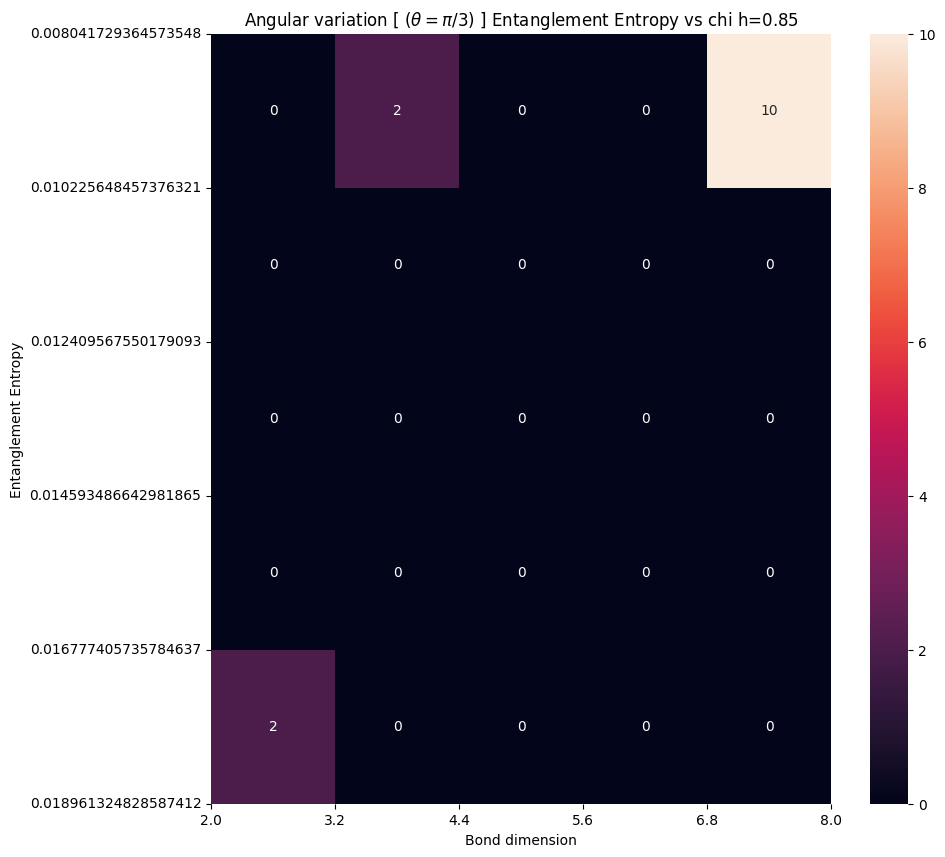

In [ ]:
array1 = f3
array2 = e3

# Create a 2D histogram using np.histogram2d()
heatmap_data, xedges, yedges = np.histogram2d(array1, array2, bins=5)

# Plot the heatmap using seaborn
ax = sns.heatmap(heatmap_data.T, annot=True, fmt=".0f")
ax.set_xticks(np.arange(len(xedges)))
ax.set_yticks(np.arange(len(yedges)))
ax.set_xticklabels(xedges, rotation=0)
ax.set_yticklabels(yedges, rotation=0)
ax.set_xlabel("Bond dimension")
ax.set_ylabel("Entanglement Entropy")
ax.set_title("Angular variation [ ($\u03B8 = \u03C0 /3$) ] Entanglement Entropy vs chi h=0.85")
plt.show()

#**Exact Diagonalization**

* # **PRACTICE for Quantum Quenching**

In [ ]:
import math
import sys
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import scipy as scipy
import scipy.integrate as integrate
import argparse
import time
import copy
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
#to work on the arguments passed on

def parse_args():
    parser = argparse.ArgumentParser(description='Dynamics of S=1/2 TFI chain')
    parser.add_argument('-N',metavar='N',dest='N',type=int,default=10,help='set Nsize (should be >=4)')
    return parser.parse_args()
def make_spin():
  S0=scipy.sparse.csr_matrix(np.array([[1.0,0.0],[0.0,1.0]],dtype=float))
  Sx=scipy.sparse.csr_matrix(np.array([[0.0,1.0],[1.0,0.0]],dtype=float))
  Sy=scipy.sparse.csr_matrix(np.array([[0.0,-1.0j],[1.0j,0.0]],dtype=complex))
  Sz=scipy.sparse.csr_matrix(np.array([[1.0,0.0],[0.0,-1.0]],dtype=float))
  return S0,Sx,Sy,Sz
def make_list_2(N):                #two site block Jzz
  list_site1=[i for i in range(N)]
  list_site2=[(i+1)%N for i in range(N)]
  list_Jzz= np.ones(N , dtype=float)
  return list_site1,list_site2,list_Jzz
def make_list_1(N):              #for left over
  list_Jz = np.ones(N , dtype=float)
  return list_Jz

def make_list_1_stag(N):
  list_Jz = np.array([1.0 if i%2 == 0 else -1.0 for i in range(N)],dtype=float)
  return list_Jz

def make_hamiltonian_2(S0,Sz,N,Nbond,list_site1,list_site2,list_Jzz): #taking care of the mutual term applied at each block
  Hamil_new = scipy.sparse.csr_matrix((2**N,2**N),dtype=float)
  for bond in range(Nbond):
    i1=list_site1[bond]
    i2=list_site2[bond]
    Jzz=list_Jzz[bond]
    SzSz = 1
    for site in range(N):
      if site==i1 or site==i2:
        SzSz=scipy.sparse.kron(SzSz,Sz,format='csr')
      else:
        SzSz=scipy.sparse.kron(SzSz,S0,format='csr')
    Hamil_new=-(Hamil_new+Jzz*SzSz)
  return Hamil_new
def make_hamiltonian_1(S0, Sz, N, list_Jz):
  Hmail_new_1 = scipy.sparse.csr_matrix((2**N, 2**N), dtype=float)
  for site1 in range(N):
    ISz = 1
    Jz = list_Jz[site1]  # Accessing the element from list_Jz
    for site2 in range(N):
      if site1 == site2:
        ISz = scipy.sparse.kron(ISz, Sz, format='csr')
      else:
        ISz = scipy.sparse.kron(ISz, S0, format='csr')
    Hmail_new_1 -= Jz * ISz  # Multiplying by the scalar Jz
  return Hmail_new_1
############################## BEGINNING ANALYSIS #########################################


# **(magnetization,loschmidt_values(analytical formula got from the internet),density imabalnce)**

In [ ]:
def epsion(J,h,k):
  return 2.0*np.sqrt(1.0+h**2-2.0*h*np.cos(k))
def diff_loschmidt_echo(J,h0,h1,k,t):
  e0 = epsion(J,h0,k)
  e1 = epsion(J,h1,k)
  denom = e0*e1
  numer = 4.0*J**2 * (h1-h0) * np.sin(k) * np.sin(e1*t)
  return np.log(1.0 - (numer/denom)**2)/(-2.0*np.pi)
def diff_loschmidt_echo_main(k,c):
  return diff_loschmidt_echo_main(c[0],c[1],c[2],k,c[3])
def integrating_loschmidt_echo(J,h0,h1,tau,dt):
  list_vt = []
  list_loschmidt_echo = []
  vmax = 2.0*j*np.min(1.0,h1)
  tmax = tau/vmax
  N = int(tmax/dt+0.1)+1
  for steps in range(N):
      t = steps*dt
      log_loschmidt_echo = integrate.quad(lambda k,c : \
          diff_loschmidt_echo_main(k,c), 0.0, np.pi, args=[J,h0,h1,t])
      list_vt.append(vmax*t)
      list_loschmidt_echo.append(log_loschmidt_echo[0])
  return list_vt, list_loschmidt_echo
def main():
  # np.set_print_options(threshold=1000)
  args=parse_args()
  N=args.N
  Nbond=N

  field_i = 1e10
  field_f = 0.1
  print("N = ",N)
  print("field_i = ", field_i)
  print("field_f = ", field_f)
  print("Nbond = ", Nbond)

  J=1.0
  tau = 1.0
  dt = 0.01
  print("J = ", J)
  print("tau = ", tau)
  print("dt = ", dt)
  ########################## ANALYTICAL ######################################

  start = time.time()
  if np.abs(field_i)<1.0 and np.abs(field_f)<1.0 and np.abs(field_f)<1e-10:
    _,list_loschmidt_echo = integrating_loschmidt_echo(J,field_i,field_f,tau,dt)
  end = time.time()
  print("time = ", end-start)

  ######################## INTERACTION #######################################

  start = time.time()
  S0,Sx,Sy,Sz = make_spin()
  list_site1,list_site2,list_Jzz = make_list_2(N)
  _,_, list_Jxx = make_list_2(N)
  list_Jz = make_list_1(N)
  list_Jx = make_list_1(N)
  list_Jx_stag = make_list_1_stag(N)
  list_Jz_stag = make_list_1_stag(N)
  print("site2",list_site2)
  print("Jzz",list_Jzz)
  print("Jx",list_Jx)
  end = time.time()
  print("time: prepare interaction",end - start)

  ####################### PREPARING HAMILTONIAN #############################
  start = time.time()
  Ham_zz = make_hamiltonian_2(S0,Sz,N,Nbond,list_site1,list_site2,list_Jzz)
  Ham_x = make_hamiltonian_1(S0,Sx,N,list_Jx)
  Ham_z = make_hamiltonian_1(S0,Sz,N,list_Jz)
  OP_xx = make_hamiltonian_2(S0,Sx,N,Nbond,list_site1,list_site2,list_Jxx)
  OP_zz = make_hamiltonian_2(S0,Sz,N,Nbond,list_site1,list_site2,list_Jzz)
  OP_x = make_hamiltonian_1(S0,Sx,N,list_Jx)
  OP_z = make_hamiltonian_1(S0,Sz,N,list_Jz)
  OP_X_stag = make_hamiltonian_1(S0,Sx,N,list_Jx_stag)
  OP_Z_stag = make_hamiltonian_1(S0,Sz,N,list_Jz_stag)
  ############### CORRELATION <mz(0)mz(1)> || <mx(0)mx(1)> ##################
  OP_Mz0Mz1 = copy.deepcopy( - OP_zz/N)
  OP_Mx0Mx1 = copy.deepcopy( - OP_xx/N)
  OP_Mx = copy.deepcopy ( -OP_x/N)
  OP_Mz = copy.deepcopy ( -OP_z/N)
  OP_Mx_stag = copy.deepcopy ( -OP_X_stag/N)
  OP_Mz_stag = copy.deepcopy ( -OP_Z_stag/N)
  end = time.time()
  print("time: prepare hamiltonian",end - start)
  ############### PREPARING : GS at T=0 #############################

  start =time.time()
  if np.abs(field_i)<1e-10:
    Ham0 = copy.deepcopy(OP_z) ##GS |+z>
  else:
    Ham0 = copy.deepcopy(Ham_zz + field_i*Ham_x)
  # Use eigsh from scipy.sparse.linalg directly to find eigenvalues and eigenvectors
  eig_val,eig_vec=scipy.sparse.linalg.eigsh(Ham0,which='SA',k=2)
  print("energy (t=0)",eig_val[0],eig_val[1])
  end = time.time()
  print("time : prepare initial state", end-start)
  ############### DYNAMICS CALCULATION ##################################

  start =time.time()
  h1=field_f
  vmax = 2.0*J*np.min([1.0,h1])
  tmax = tau/vmax
  Nsteps = int(tmax/dt + 0.1)+1
  timei = 0.0
  timef = tmax
  steps = Nsteps
  Hamiltonian = copy.deepcopy(Ham_zz + field_f*Ham_x + field_f*Ham_z)
  psi0 = copy.deepcopy( eig_vec[:,0])
  ret = scipy.sparse.linalg.expm_multiply((-1j)*Hamiltonian,eig_vec[:,0],start=timei,stop=timef,num=steps,endpoint=True)
  ene0 = [(np.dot(np.conjugate(ret[i]),Ham0.dot(ret[i]))/np.dot(np.conjugate(ret[i]),ret[i])).real for i in range(steps)]
  ene= [(np.dot(np.conjugate(ret[i]),Hamiltonian.dot(ret[i]))/np.dot(np.conjugate(ret[i]),ret[i])).real for i in range(steps)]
  mx0mx1 = [(np.dot(np.conjugate(ret[i]),OP_Mx0Mx1.dot(ret[i]))/np.dot(np.conjugate(ret[i]),ret[i])).real for i in range(steps)]
  mz0mz1 = [(np.dot(np.conjugate(ret[i]),OP_Mz0Mz1.dot(ret[i]))/np.dot(np.conjugate(ret[i]),ret[i])).real for i in range(steps)]
  mx = [(np.dot(np.conjugate(ret[i]),OP_Mx.dot(ret[i]))/np.dot(np.conjugate(ret[i]),ret[i])).real for i in range(steps)]
  mz = [(np.dot(np.conjugate(ret[i]),OP_Mz.dot(ret[i]))/np.dot(np.conjugate(ret[i]),ret[i])).real for i in range(steps)]
  mx_stag = [(np.dot(np.conjugate(ret[i]),OP_Mx_stag.dot(ret[i]))/np.dot(np.conjugate(ret[i]),ret[i])).real for i in range(steps)]
  mz_stag = [(np.dot(np.conjugate(ret[i]),OP_Mz_stag.dot(ret[i]))/np.dot(np.conjugate(ret[i]),ret[i])).real for i in range(steps)]
  loschmidt_echo = [(np.abs(np.dot(np.conjugate(ret[i]),psi0))**2 / np.dot(np.conjugate(ret[i]),ret[i]) / np.dot(np.conjugate(psi0),psi0)).real for i in range(steps)]
  print("ene0",ene0)
  print("ene",ene)
  print("mz0mz1",mz0mz1)
  print("mx0mx1",mx0mx1)
  print("mx",mx)
  print("mz",mz)
  print("mx_stag",mx_stag)
  print("mz_stag",mz_stag)
  print("loschmidt_echo",loschmidt_echo)
  print("The density imbalance = ",(4/N)*mz0mz1)
  end = time.time()
  print("time : calculate dynamics ", end-start)

if __name__ == "__main__":
  ############### IMPORTING SYSTEM SIZE IN PLACE OF 30 #########################
  sys.argv = ['myscript.py','-N','20']
  main()

In [ ]:
!pip install quspin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.9/199.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.0/282.0 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5